In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib as mpl

# Plot Formatting

In [ ]:
# clrs = sns.color_palette('Set1')
# clrs[5] = (255/255, 200/255, 80/255)
# colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
# #mpl.rc('text', usetex=True)

plt.rc('axes', axisbelow=True, 
       grid=False)#, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
# plt.rcParams['figure.dpi'] = 75

# Convenience Functions

In [2]:
def mask_contamination(labline, mask_dict):
    mask_idx = mask_dict[labline]
    if isinstance(mask_idx, list):
        mask=np.ones(300, dtype=bool)
        mask[mask_idx[0]:mask_idx[1]] = False
        return mask
    else:
        mask=np.zeros(300, dtype=bool)
        mask[mask_idx:] = True
        return mask
    
# labline: mask array
line_mask_dict = {
    1453.1:200,
    1555.89:[75,175],
    1463.83:200,
    1613.72:[75,200],
    1415.33:180,
    1407.29:200,
    1468.39:[75,299], #mask out MgII transition at 1466.55
    1407.29: [75,250],
    1435.05: [80,299], #High velocity component
    1636.34: [75,190]
}

# Read in Data

In [3]:
# line_df = pd.read_pickle(os.path.join('data', 'line_df_local.pkl'))
# blue_df = pd.read_pickle(os.path.join('data', 'blue_df.pkl'))
# red_df = pd.read_pickle(os.path.join('data', 'red_df.pkl'))

line_df = pd.read_pickle(os.path.join('data', 'line_df_coadded.pkl'))
blue_df = pd.read_pickle(os.path.join('data', 'blue_df_coadded.pkl'))
red_df = pd.read_pickle(os.path.join('data', 'red_df_coadded.pkl'))

In [4]:
all_df = pd.concat([blue_df, line_df, red_df])

In [ ]:
prog_df = pd.read_pickle(os.path.join('data', 'line_prog_df_local.pkl'))
blue_df = pd.read_pickle(os.path.join('data', 'blue_prog_df.pkl'))
red_df = pd.read_pickle(os.path.join('data', 'red_prog_df.pkl'))

# Fit Comparisons

In [ ]:
BIC1_mean = np.mean(prog_df['BIC1'])
BIC2_mean = np.mean(prog_df['BIC2'])
plt.hist(line_df['BIC1'], histtype='step', label='One Gauss Fit')
plt.hist(line_df['BIC2'], histtype='step', label='Two Gauss Fit')
plt.legend()
plt.xlabel('Bayesian Information Criterion Value')
plt.ylabel('Number of Progression Coadded Lines')
plt.title('All Progression BIC Value Comparison')
plt.text(0.05, 0.95, f'Mean BIC 1 = {BIC1_mean:0.2f}',
                            transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Mean BIC 2 = {BIC2_mean:0.2f}',
                            transform=plt.gca().transAxes, verticalalignment='top')
plt.show()

In [ ]:
for transition in line_df['transition'].unique():
    BIC1_mean = np.mean(line_df[line_df['transition']==transition]['BIC1'])
    BIC2_mean = np.mean(line_df[line_df['transition']==transition]['BIC2'])
    plt.hist(line_df[line_df['transition']==transition]['BIC1'], histtype='step', label='One Gauss Fit')
    plt.hist(line_df[line_df['transition']==transition]['BIC2'], histtype='step', label='Two Gauss Fit')
    plt.legend()
    plt.xlabel('Bayesian Information Criterion Value')
    plt.ylabel('Number of Progression Coadded Lines')
    plt.title(f'{transition} BIC Value Comparison')
    plt.text(0.05, 0.95, f'Mean BIC 1 = {BIC1_mean:0.2f}',
                                transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.05, 0.90, f'Mean BIC 2 = {BIC2_mean:0.2f}',
                                transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()

In [ ]:
for transition in blue_df['transition'].unique():
    BIC1_mean = np.mean(blue_df[blue_df['transition']==transition]['BIC1'])
    BIC2_mean = np.mean(blue_df[blue_df['transition']==transition]['BIC2'])
    plt.hist(blue_df[blue_df['transition']==transition]['BIC1'], histtype='step', label='One Gauss Fit')
    plt.hist(blue_df[blue_df['transition']==transition]['BIC2'], histtype='step', label='Two Gauss Fit')
    plt.legend()
    plt.xlabel('Bayesian Information Criterion Value')
    plt.ylabel('Number of Progression Coadded Lines')
    plt.title(f'{transition} BIC Value Comparison')
    plt.text(0.05, 0.95, f'Mean BIC 1 = {BIC1_mean:0.2f}',
                                transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.05, 0.90, f'Mean BIC 2 = {BIC2_mean:0.2f}',
                                transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()

In [ ]:
plt.hist(prog_df['BIC2']-prog_df['BIC1'], histtype='step', label='Model BIC comparison')
plt.xlabel('Bayesian Information Criterion Value')
plt.ylabel('Number of Progression Coadded Lines')
plt.title('BIC 2 - BIC 1')
plt.show()

In [ ]:
def calculate_chi2(df):
    chi2_single = []
    chi2_double = []
    red_chi2_single = []
    red_chi2_double = []

    for _, row in df.iterrows():
        f_obs = np.array(row['flux'], dtype=float)
        f_err = np.array(row['fluxerr'], dtype=float)
        f_model_single = np.array(row['gauss_flux'], dtype=float)
        f_model_double = np.array(row['double_gauss_flux'], dtype=float)

        # apply mask if labline has one
        if row['labline'] in line_mask_dict.keys():
            mask = mask_contamination(row['labline'], line_mask_dict)
            f_obs = f_obs[~mask]
            f_err = f_err[~mask]

        chi2_1 = np.sum(((f_obs - f_model_single) / f_err) ** 2)
        chi2_2 = np.sum(((f_obs - f_model_double) / f_err) ** 2)
        chi2_single.append(chi2_1)
        chi2_double.append(chi2_2)

        #calculate reeduced chi2
        red_chi2_1 = chi2_1/(len(f_obs) - len(row['params1']))
        red_chi2_2 = chi2_2/(len(f_obs) - len(row['params2']))
        red_chi2_single.append(red_chi2_1)
        red_chi2_double.append(red_chi2_2)

    return red_chi2_single, red_chi2_double

red_chi2_single, red_chi2_double = calculate_chi2(blue_df)
chi21_mean = np.mean(red_chi2_single)
chi22_mean = np.mean(red_chi2_double)
plt.hist(red_chi2_single, histtype='step', label='One Gauss Fit')
plt.hist(red_chi2_double, histtype='step', label='Two Gauss Fit')
plt.legend()
plt.xlabel(r'$\chi^2$')
plt.ylabel('Number of Progression Coadded Lines')
plt.title(r'All Progression $chi^2$ Value Comparison')
plt.text(0.05, 0.95, f'Mean chi2 1 = {chi21_mean:0.2f}',
                            transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Mean chi2 2 = {chi22_mean:0.2f}',
                            transform=plt.gca().transAxes, verticalalignment='top')
plt.show()

# Residuals

In [ ]:
#For each lab line, take the residual between the data and model
for line in all_df['labline'].unique():
    sub_df = all_df[all_df['labline']==line]
    residuals1 = []
    residuals2 = []
    plt.figure()
    plt.title(f"{line} {sub_df['transition'].iloc[0]}")
    for _, row in sub_df.iterrows():
        f_obs = row['flux']
        x_obs = row['velocity']
        if row['labline'] in line_mask_dict.keys():
            mask = mask_contamination(row['labline'], line_mask_dict)
            f_obs = f_obs[~mask]
            x_obs = x_obs[~mask]
        resid1 = row['gauss_flux']-f_obs
        resid2 = row['double_gauss_flux']-f_obs
        residuals1.append(resid1)
        residuals2.append(resid2)
        plt.plot(x_obs, np.mean(residuals1, axis=0), color='red', alpha=0.2)
        plt.plot(x_obs, np.mean(residuals2, axis=0), color='blue', alpha=0.2)
    plt.plot(x_obs, np.mean(residuals1, axis=0), color='black', label = 'Residuals 1')
    plt.plot(x_obs, np.mean(residuals2, axis=0), color='gray', ls = '--', label = 'Residuals 2')
    plt.legend()
    plt.show()

In [ ]:
#For each lab line, take the residual between the data and DOUBLE GAUSS model
for line in all_df['labline'].unique():
    sub_df = all_df[all_df['labline']==line]
    residuals = []
    plt.figure()
    plt.title(f"{line} {sub_df['transition'].iloc[0]}")
    for _, row in sub_df.iterrows():
        f_obs = row['flux']
        x_obs = row['velocity']
        if row['labline'] in line_mask_dict.keys():
            mask = mask_contamination(row['labline'], line_mask_dict)
            f_obs = f_obs[~mask]
            x_obs = x_obs[~mask]
        resid = row['double_gauss_flux']-f_obs
        residuals.append(resid)
        plt.plot(x_obs, np.mean(residuals, axis=0), color='red', alpha=0.2)
    plt.plot(x_obs, np.mean(residuals, axis=0), color='black')
    plt.show()

# Blue-shifted peaks

In [ ]:
#Plot velocity difference (not-absolute) from zero by labline
for line in all_df['labline'].unique():
    sub_df = all_df[all_df['labline']==line]
    blue_shift = []
    for _, row in sub_df.iterrows():
        blue_shift.append(row['velocity'][np.argmax(row['gauss_flux'])].value)
    plt.title(f"{line} {sub_df['transition'].iloc[0]}")
    plt.scatter(sub_df['year'].unique(), blue_shift)
    plt.gca().set_xticklabels(sub_df['year'].unique(), rotation=60, fontsize=10)
    plt.ylabel('Velocity shift from center (km/s)')
    plt.xlabel('Year')
    plt.show()

# Time series Parameter Plots

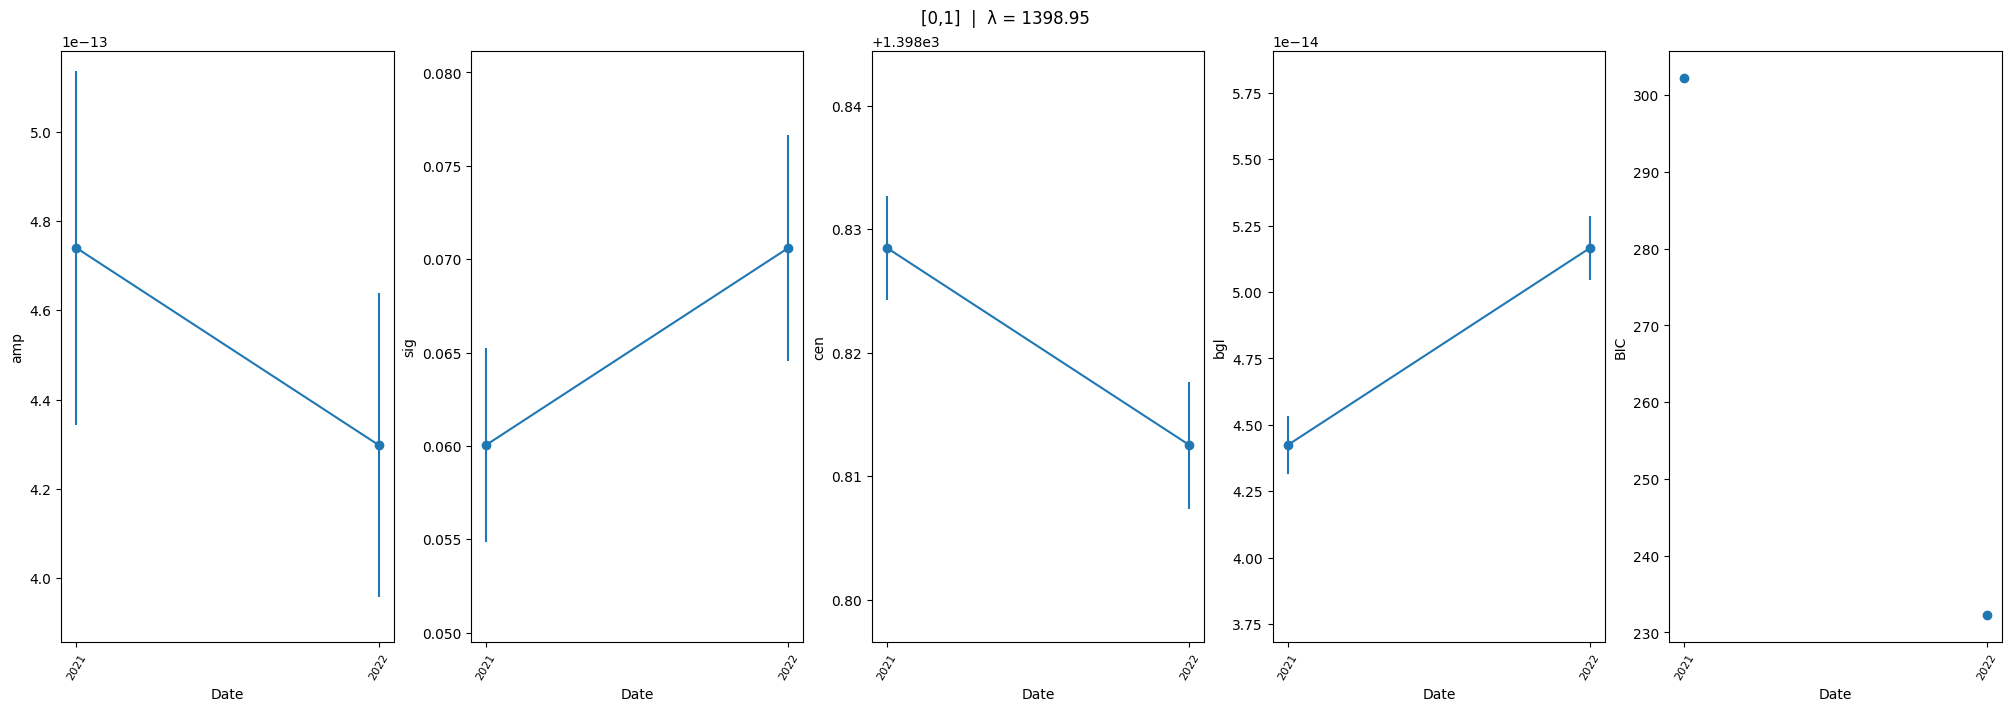

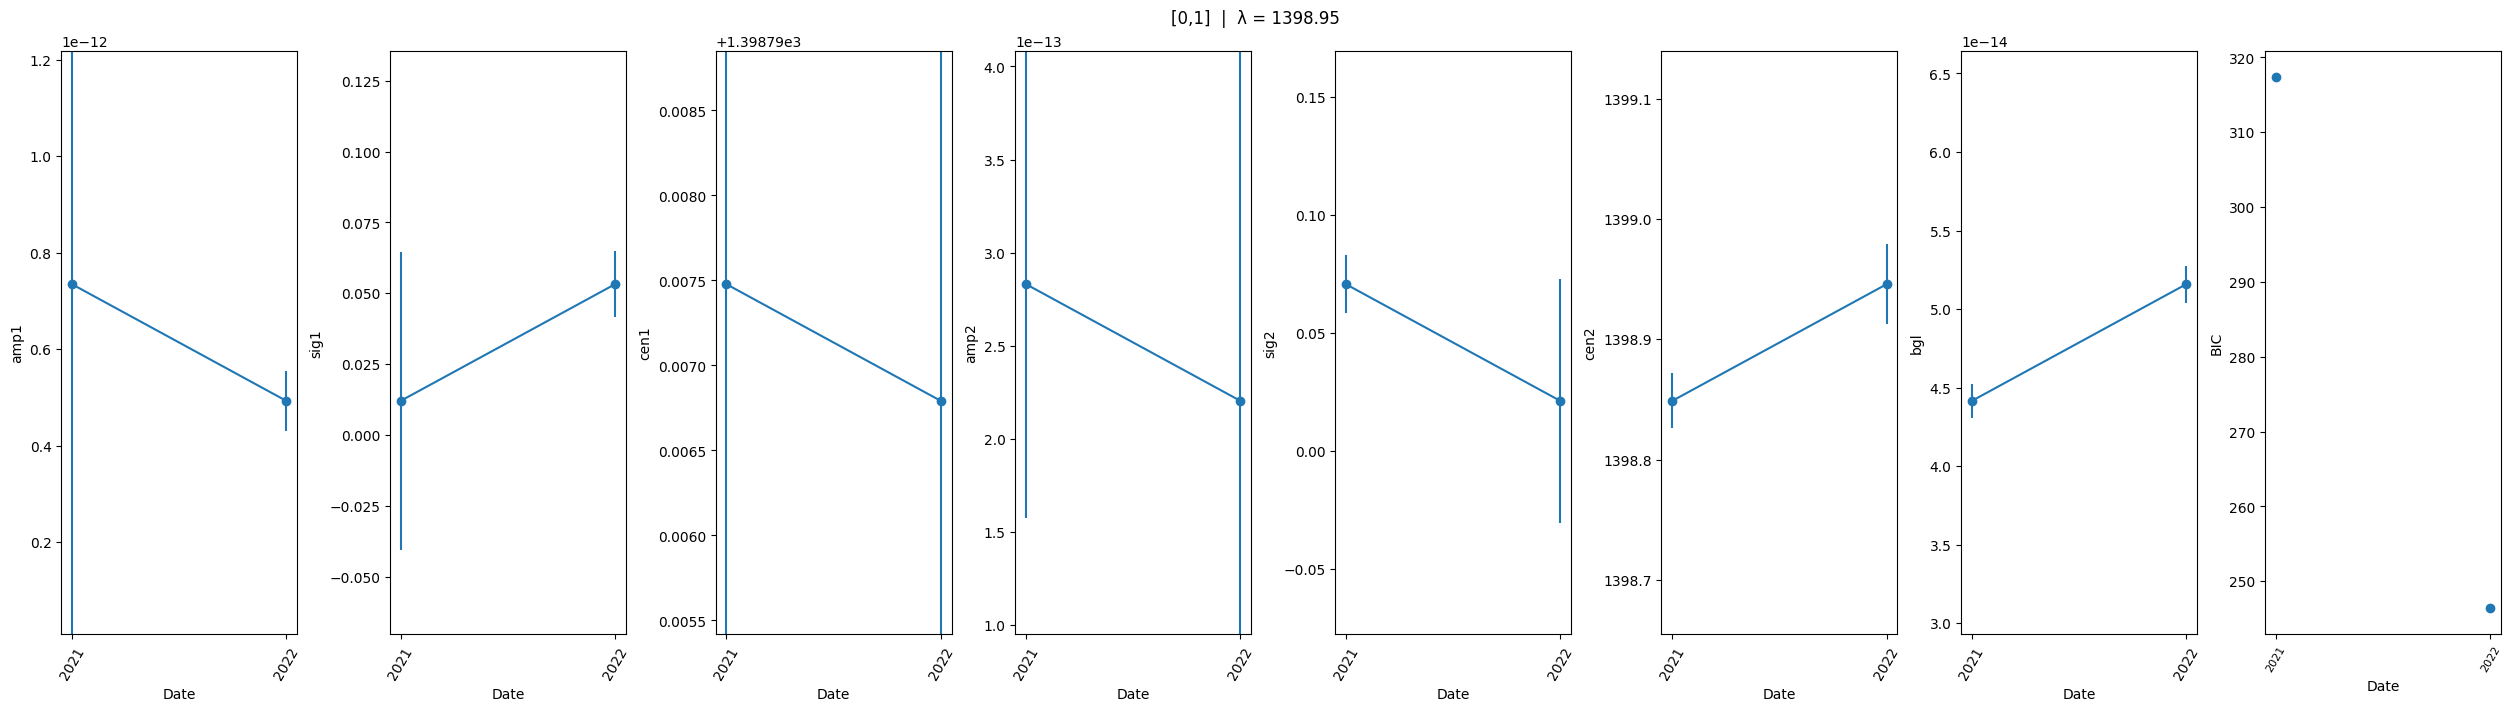

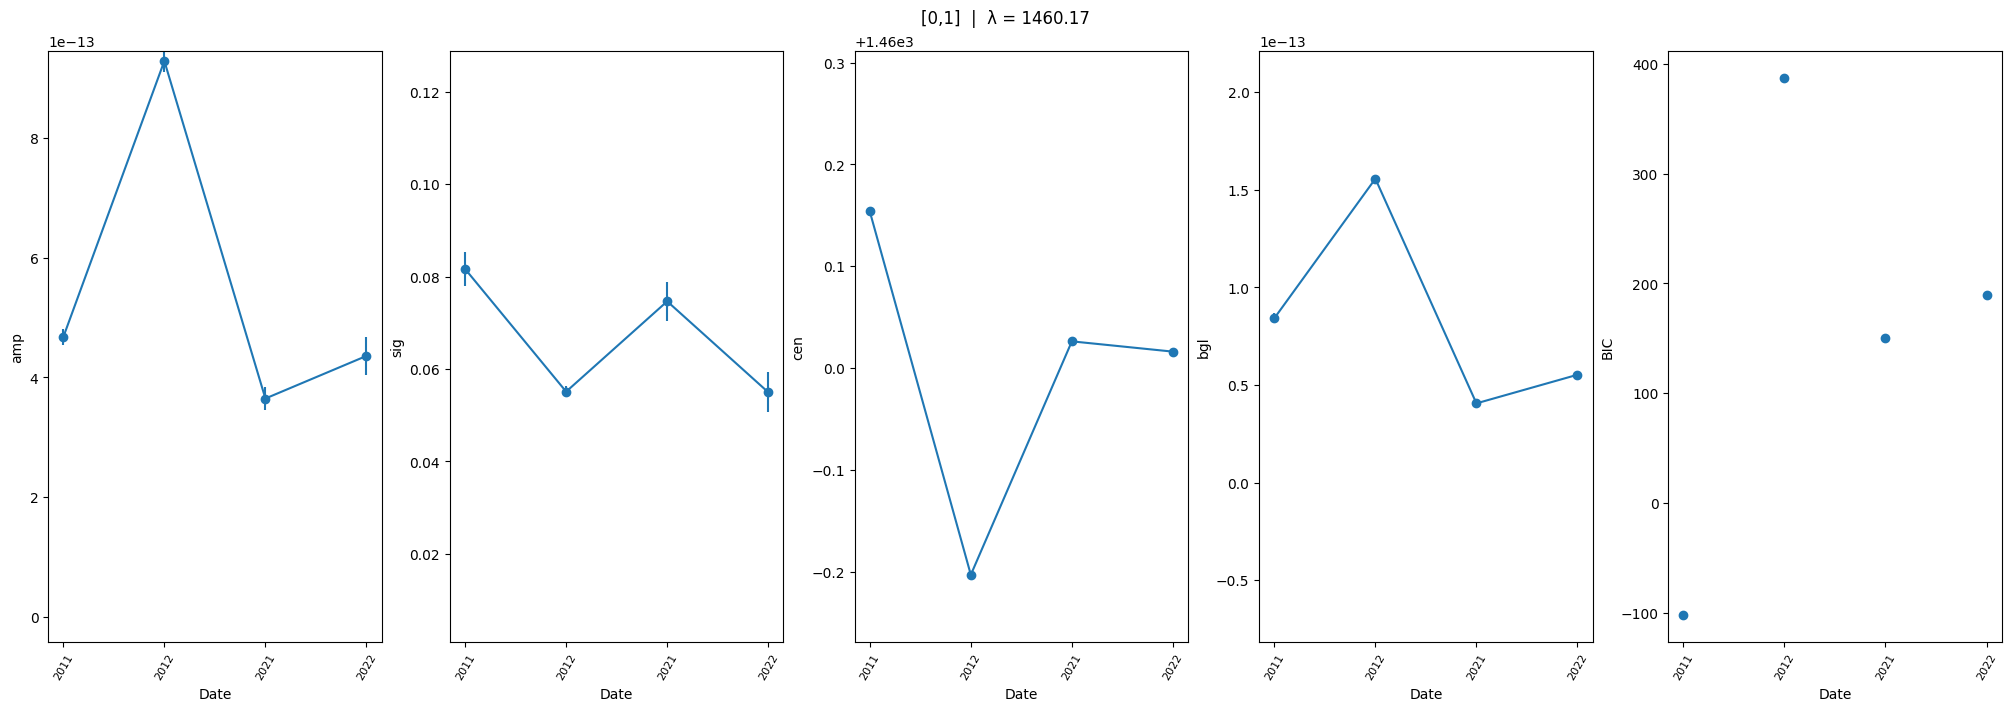

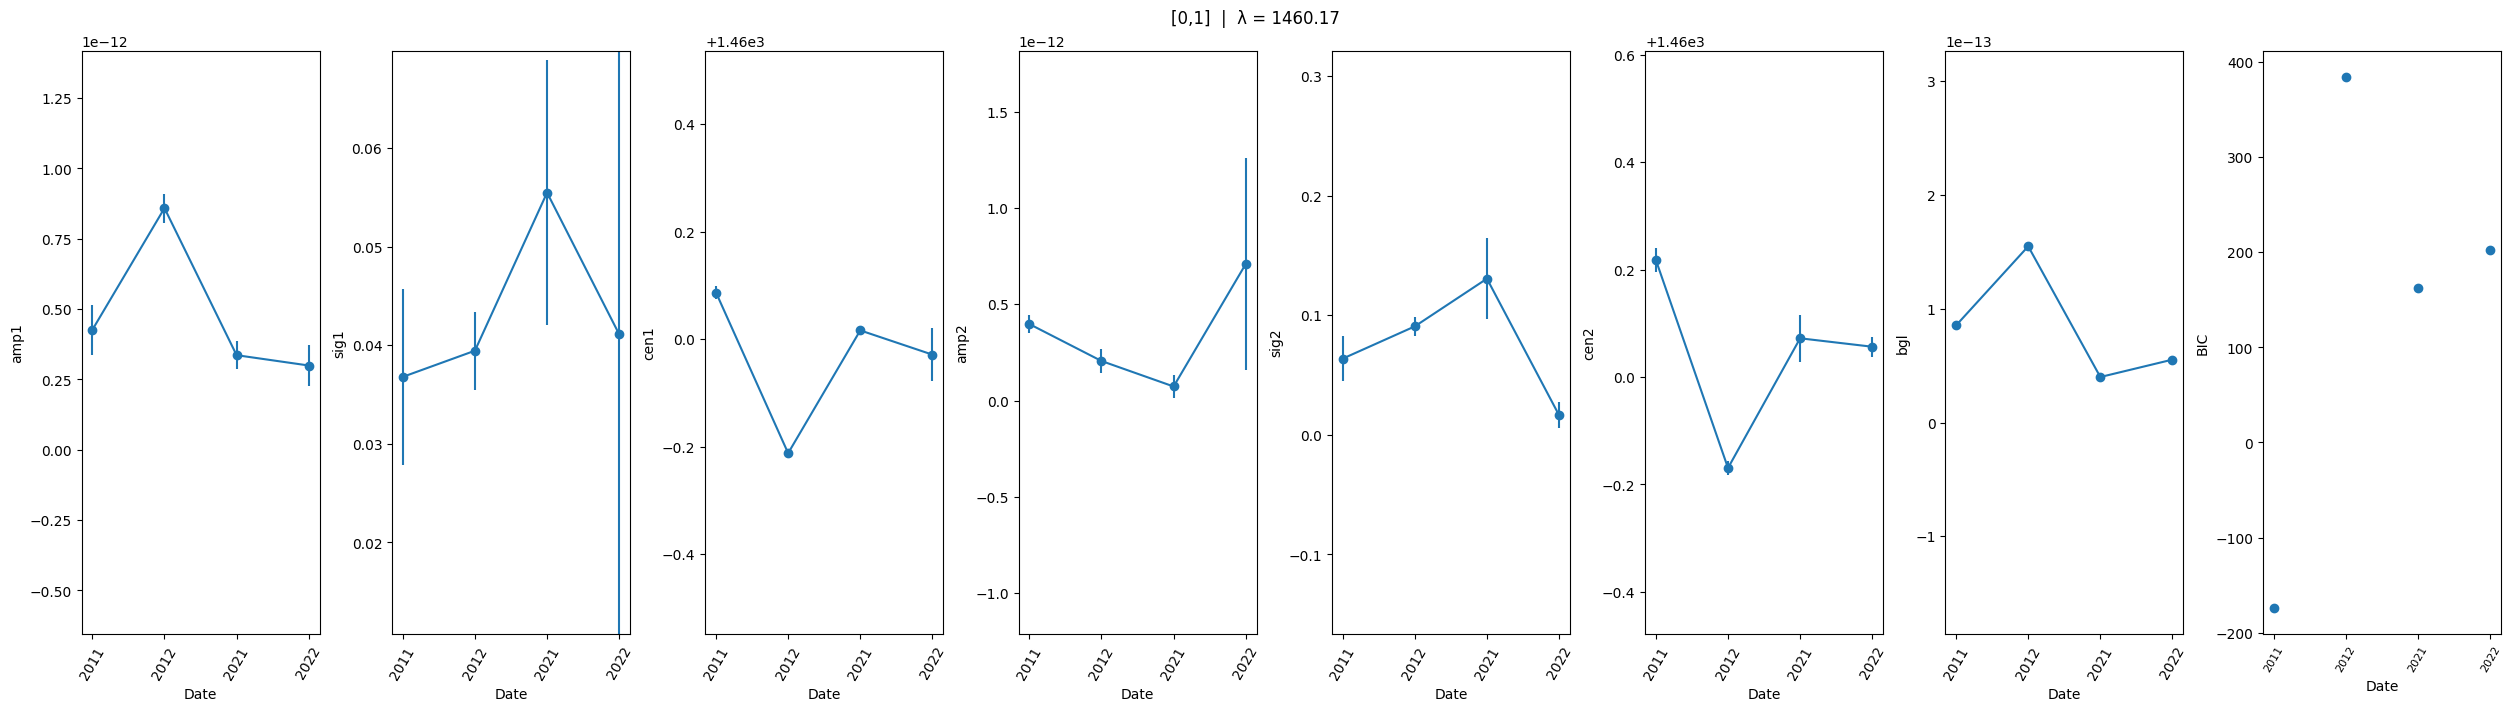

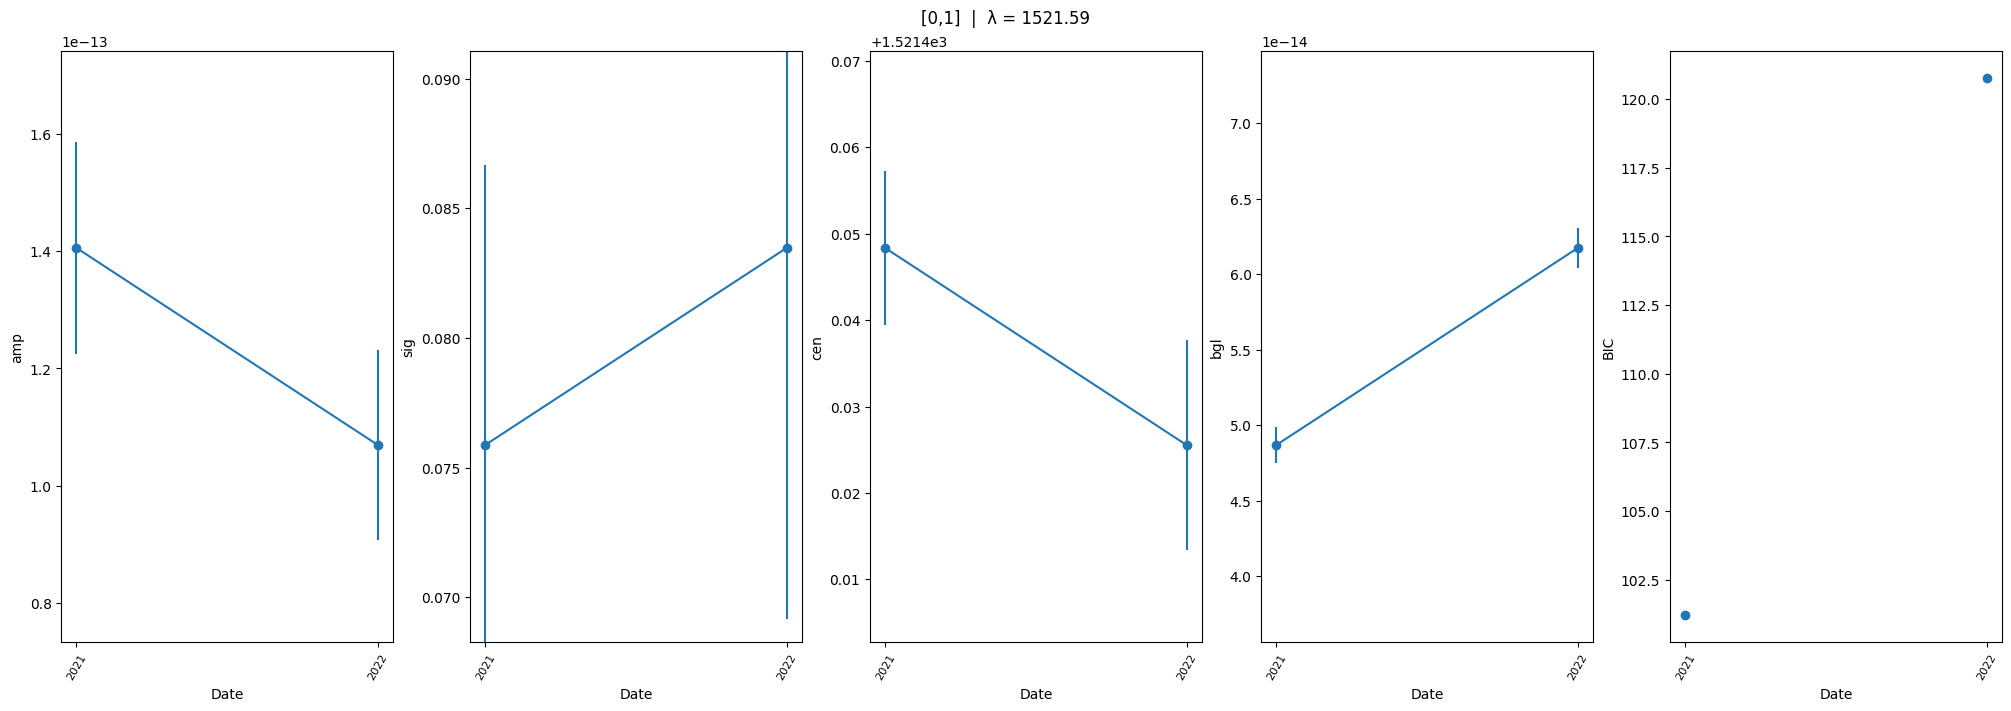

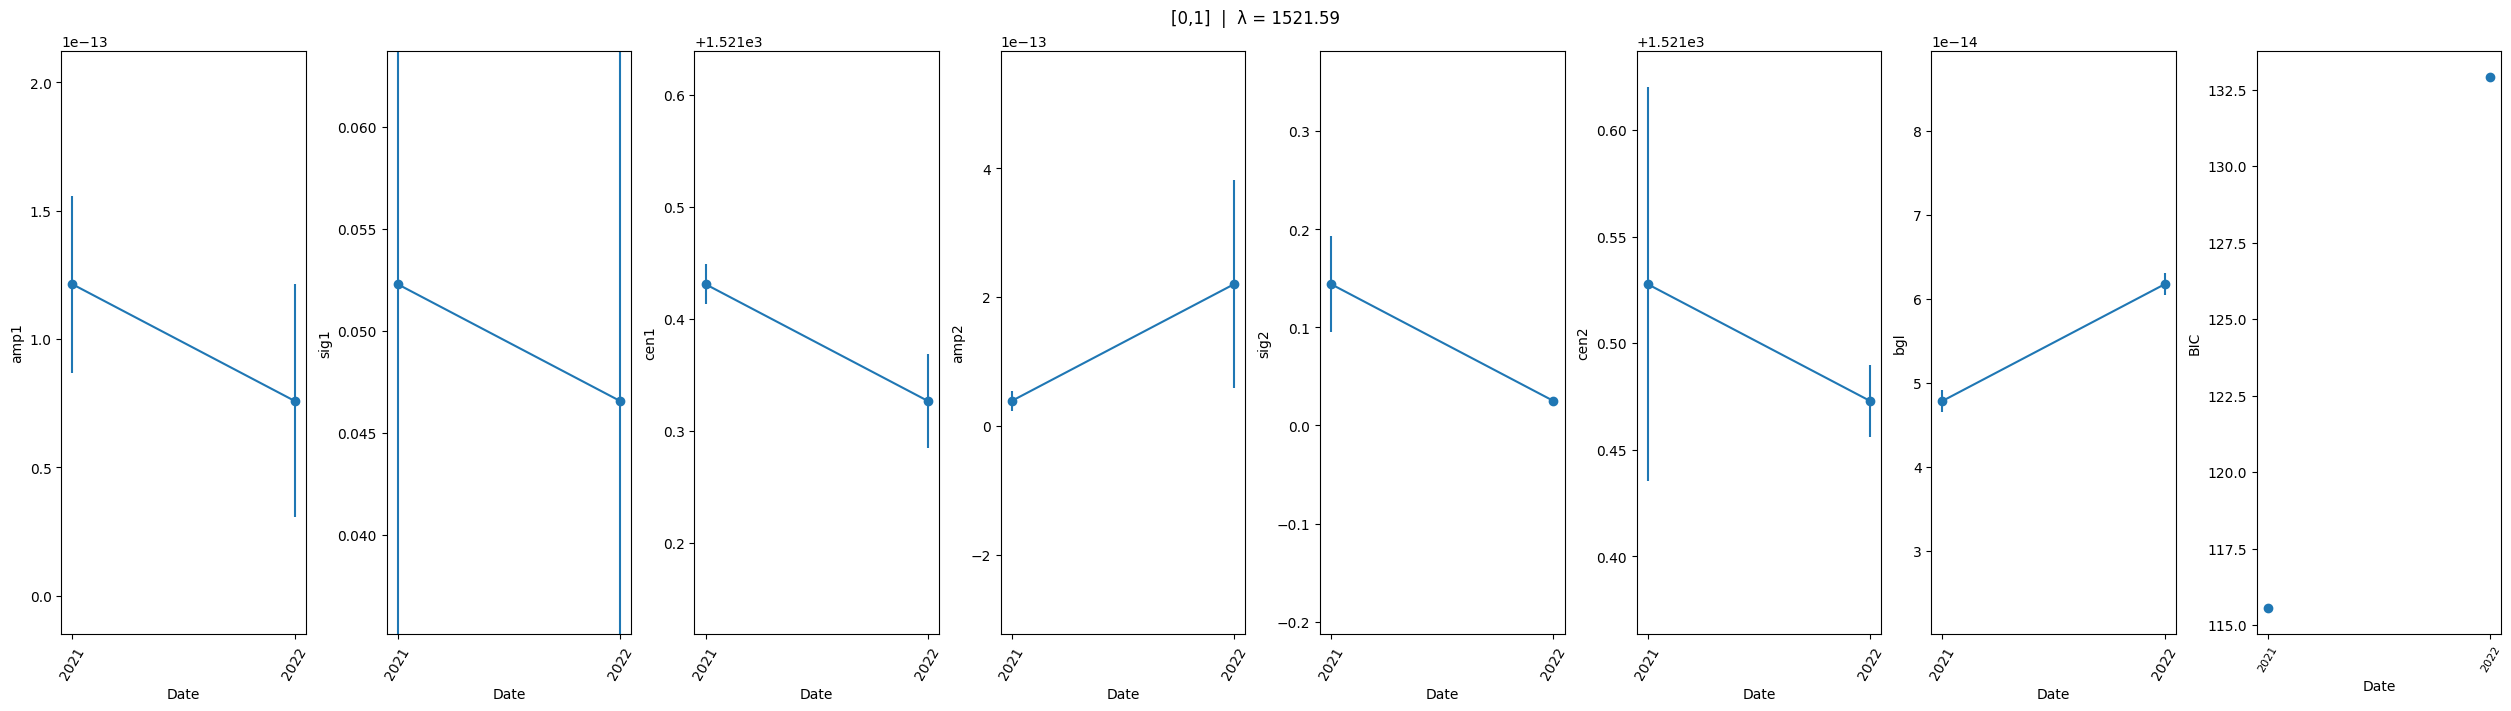

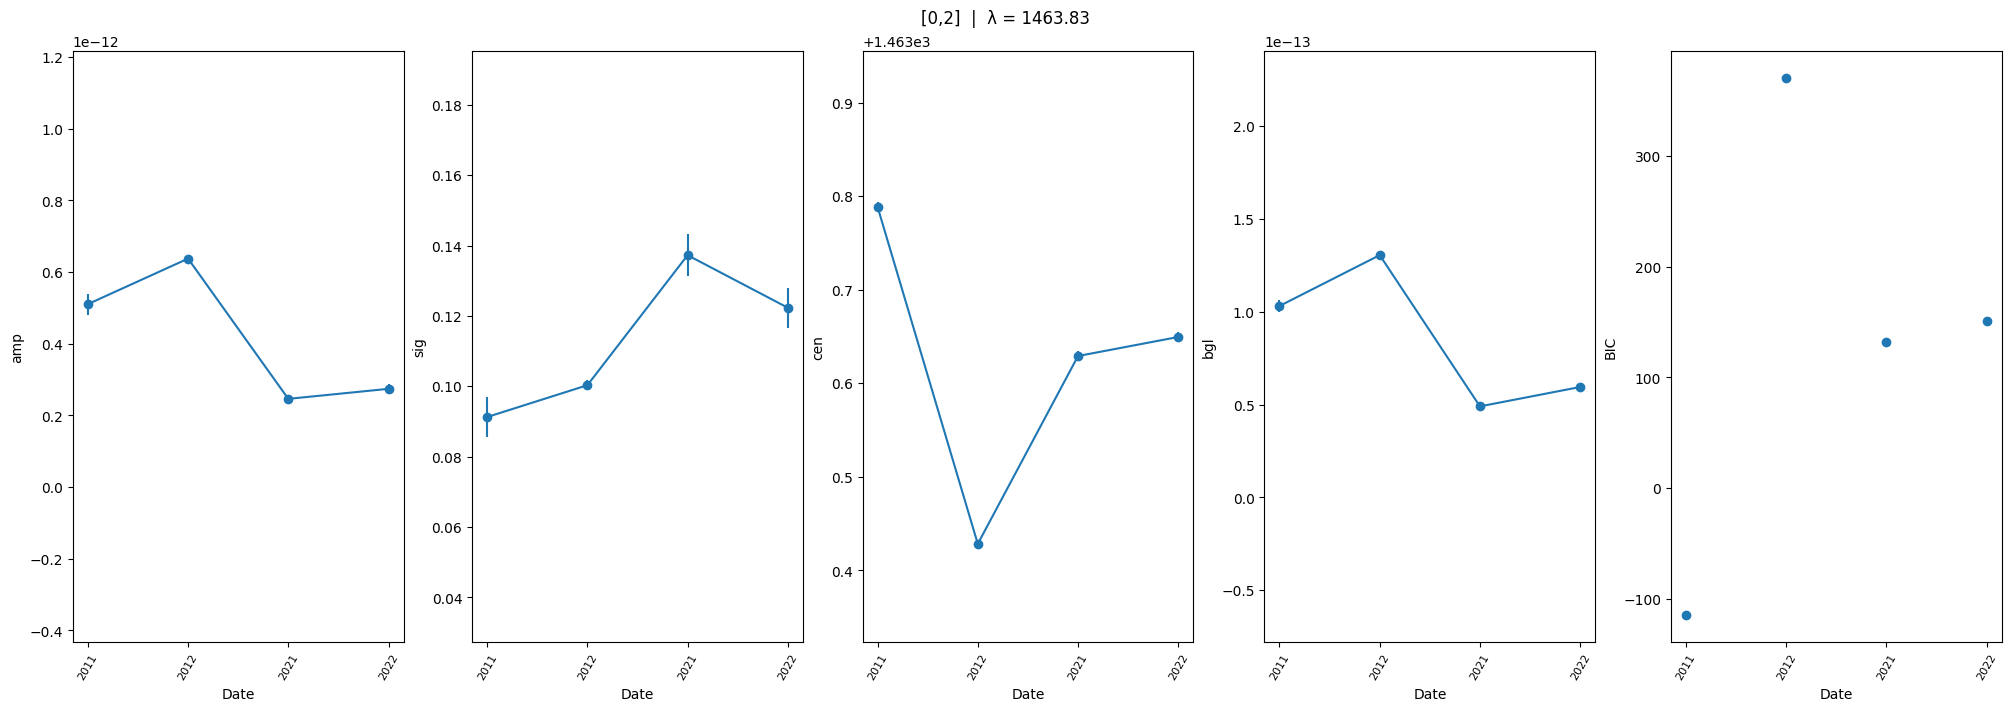

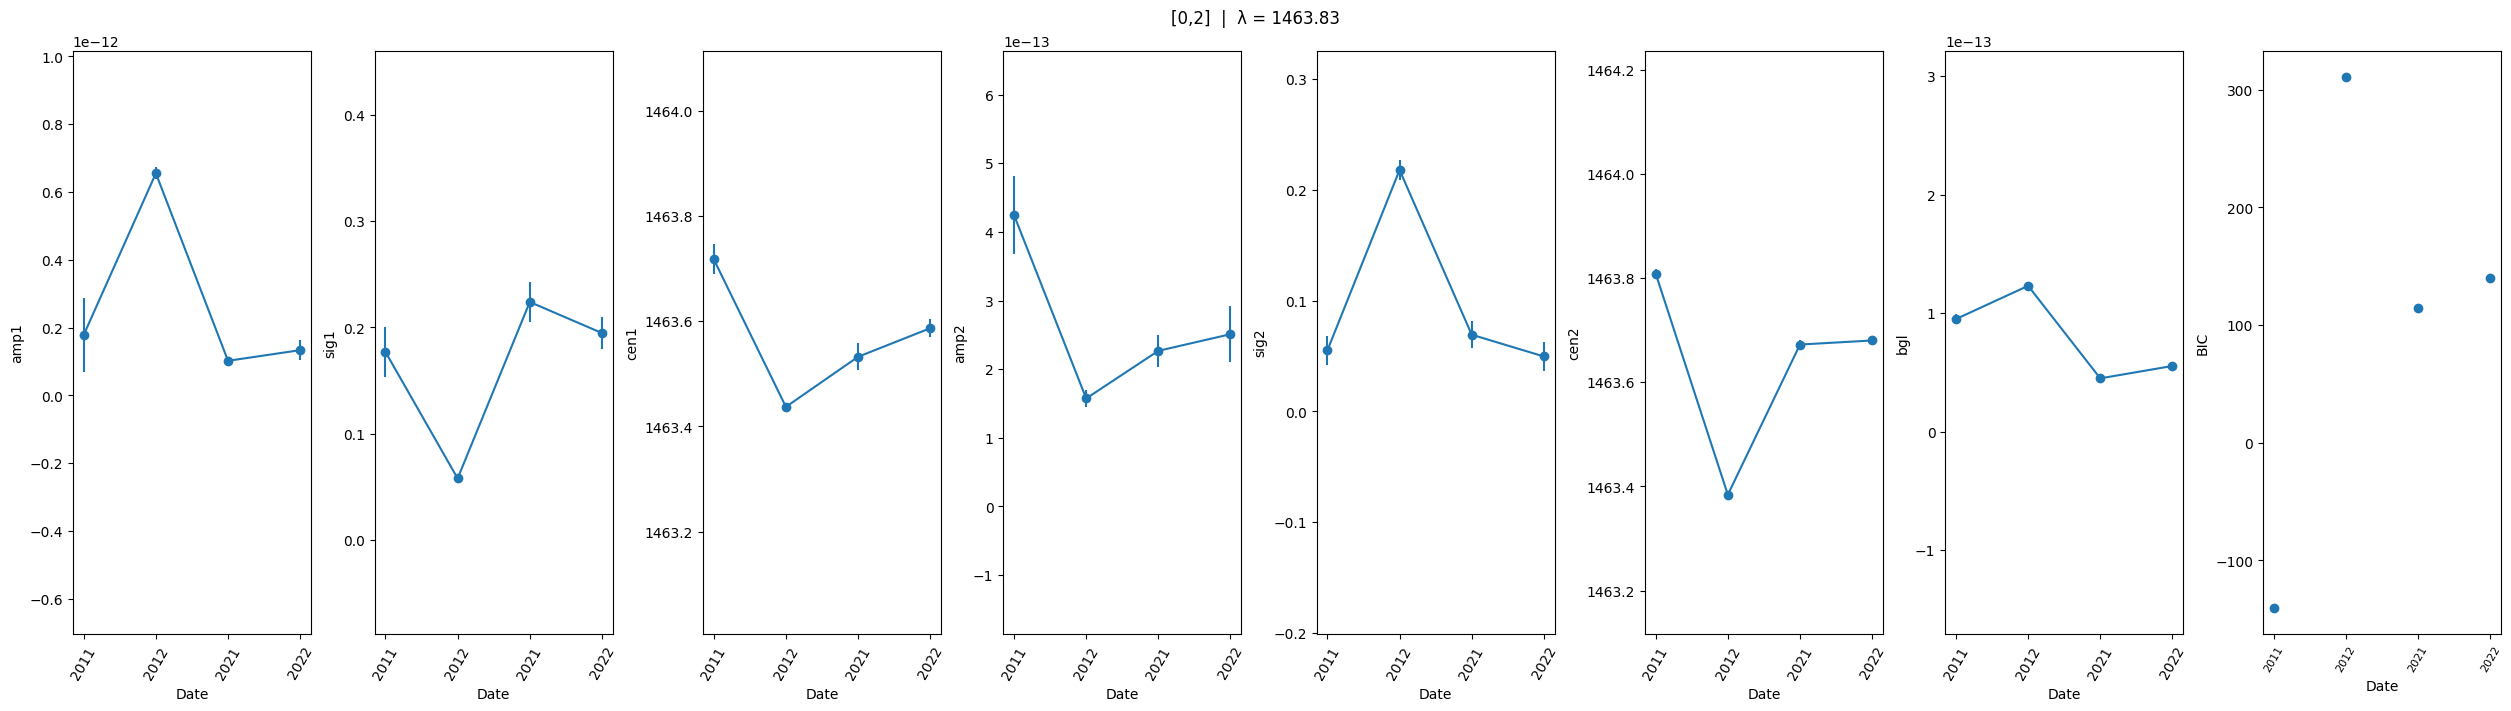

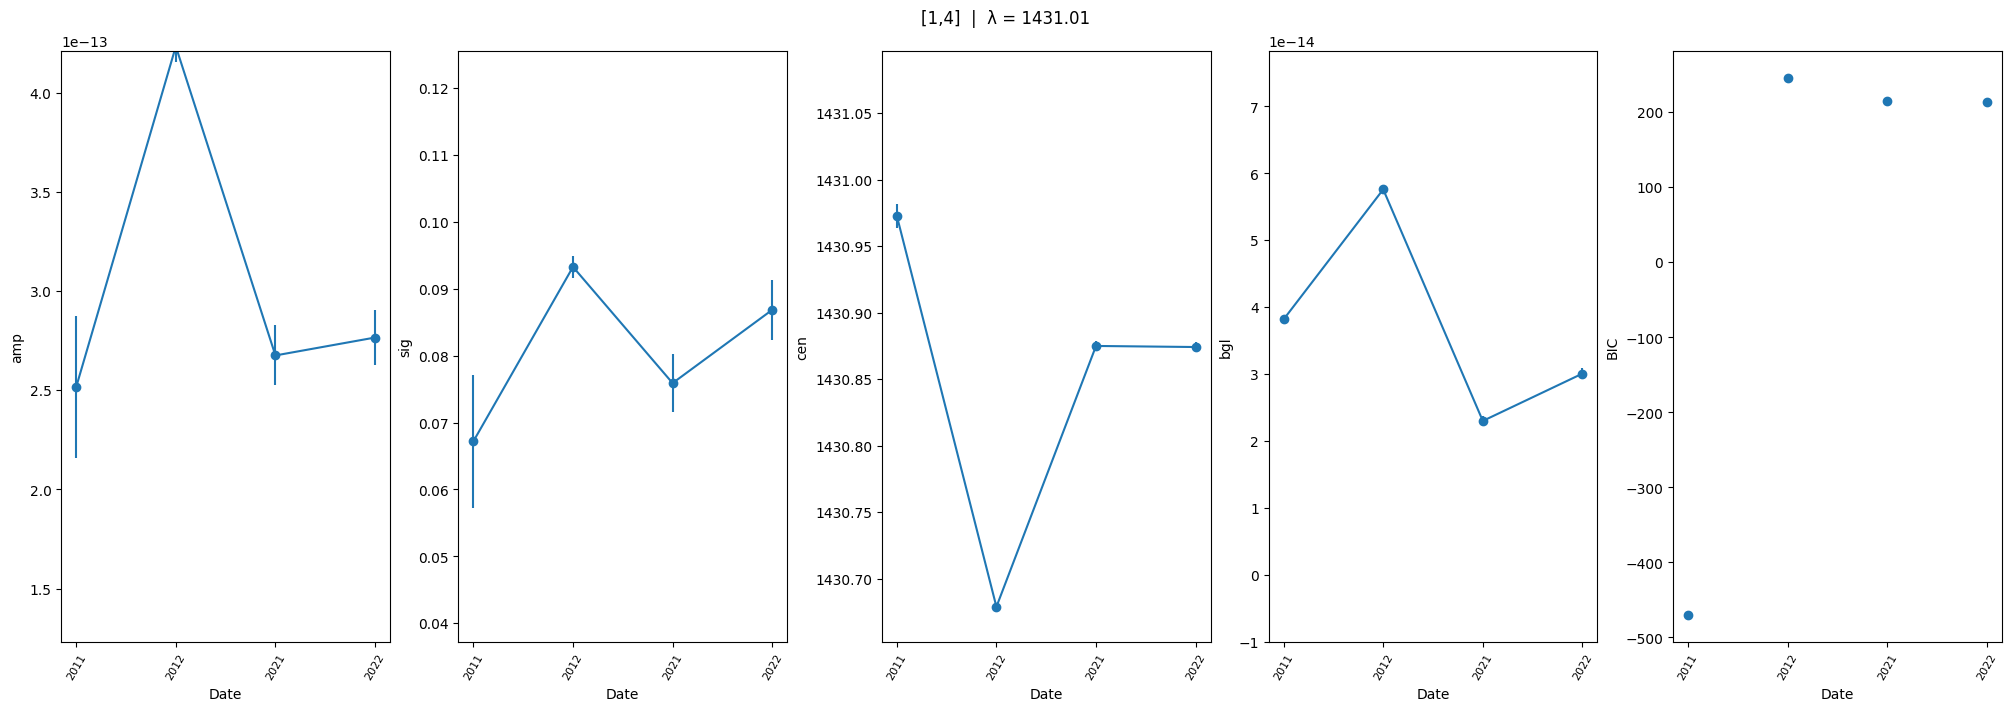

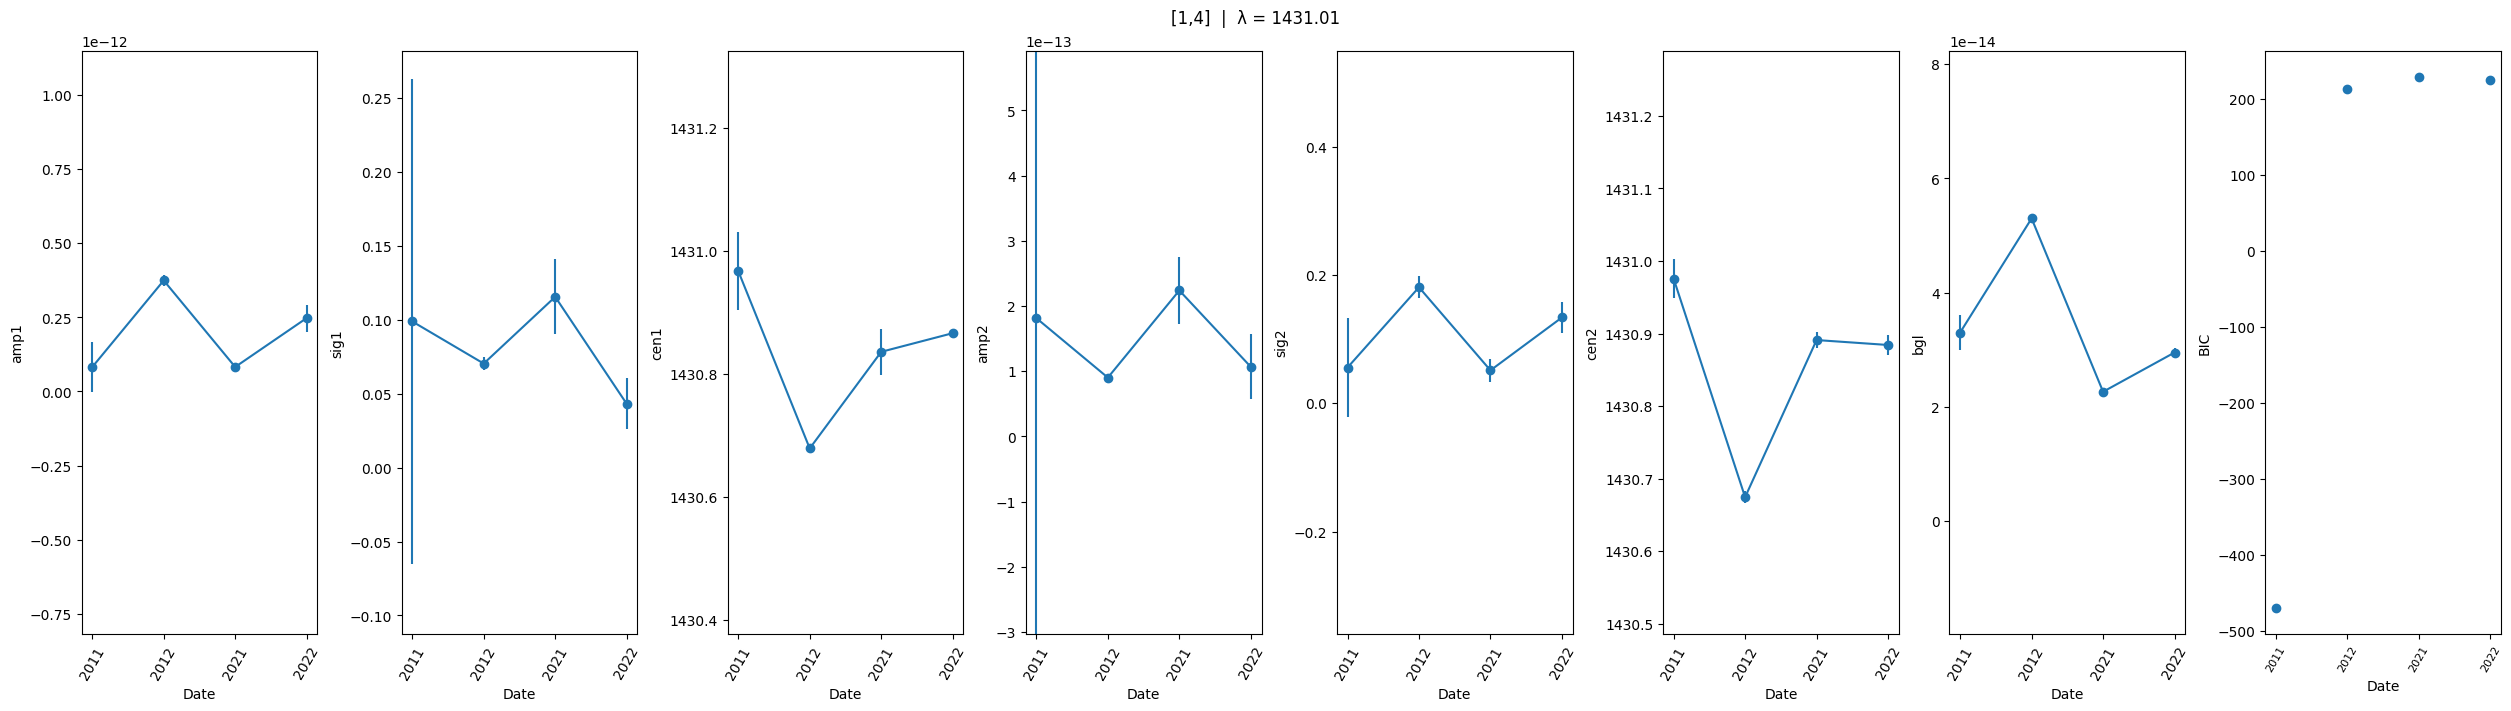

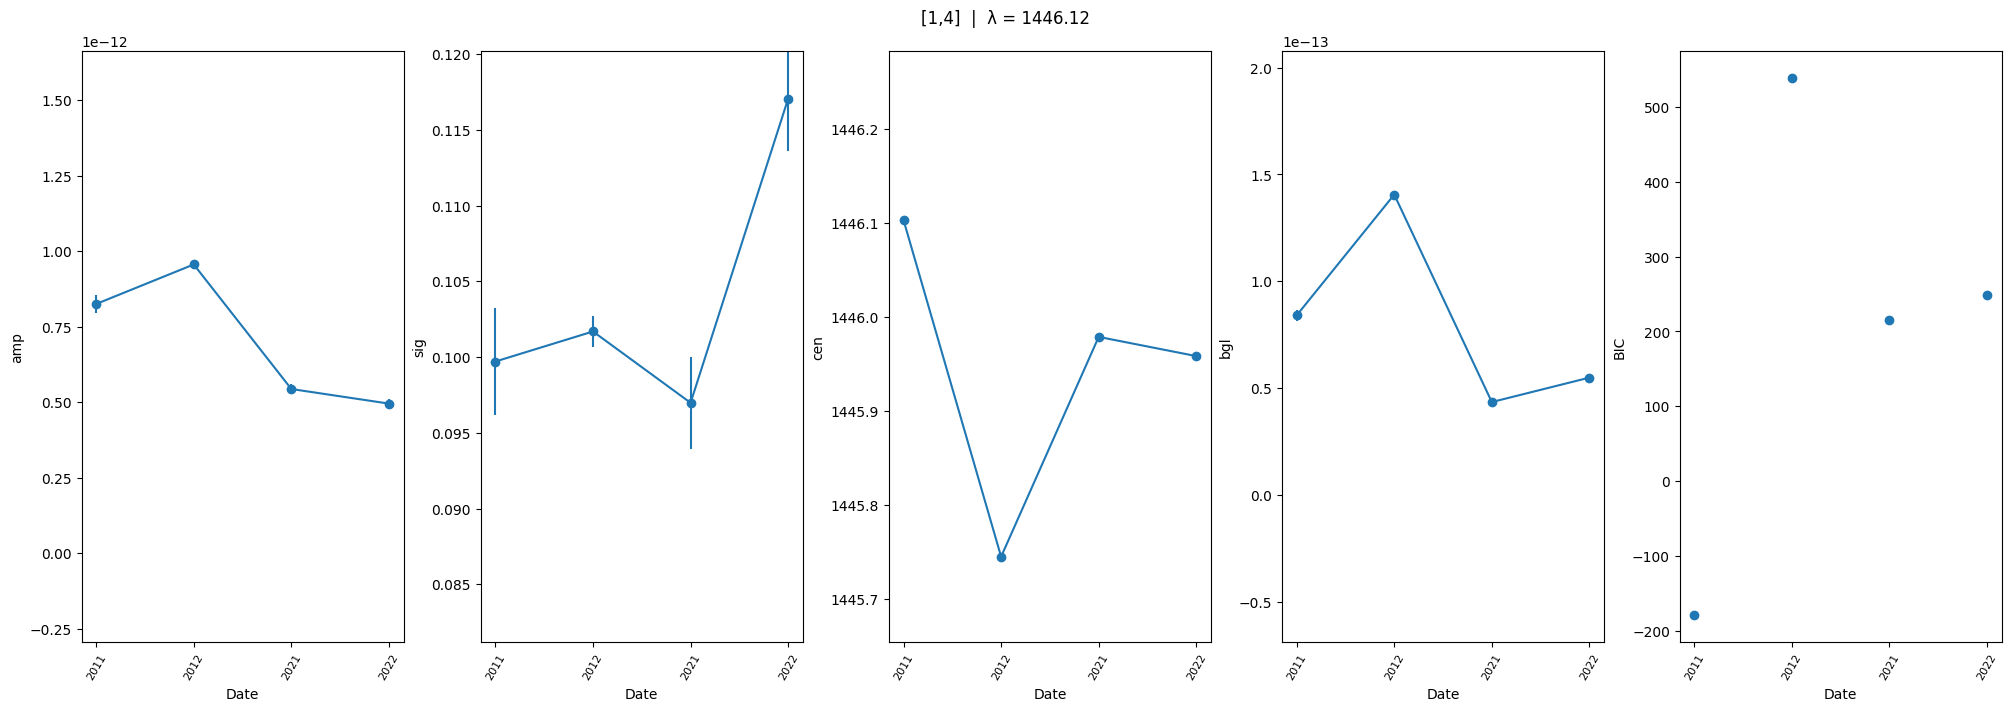

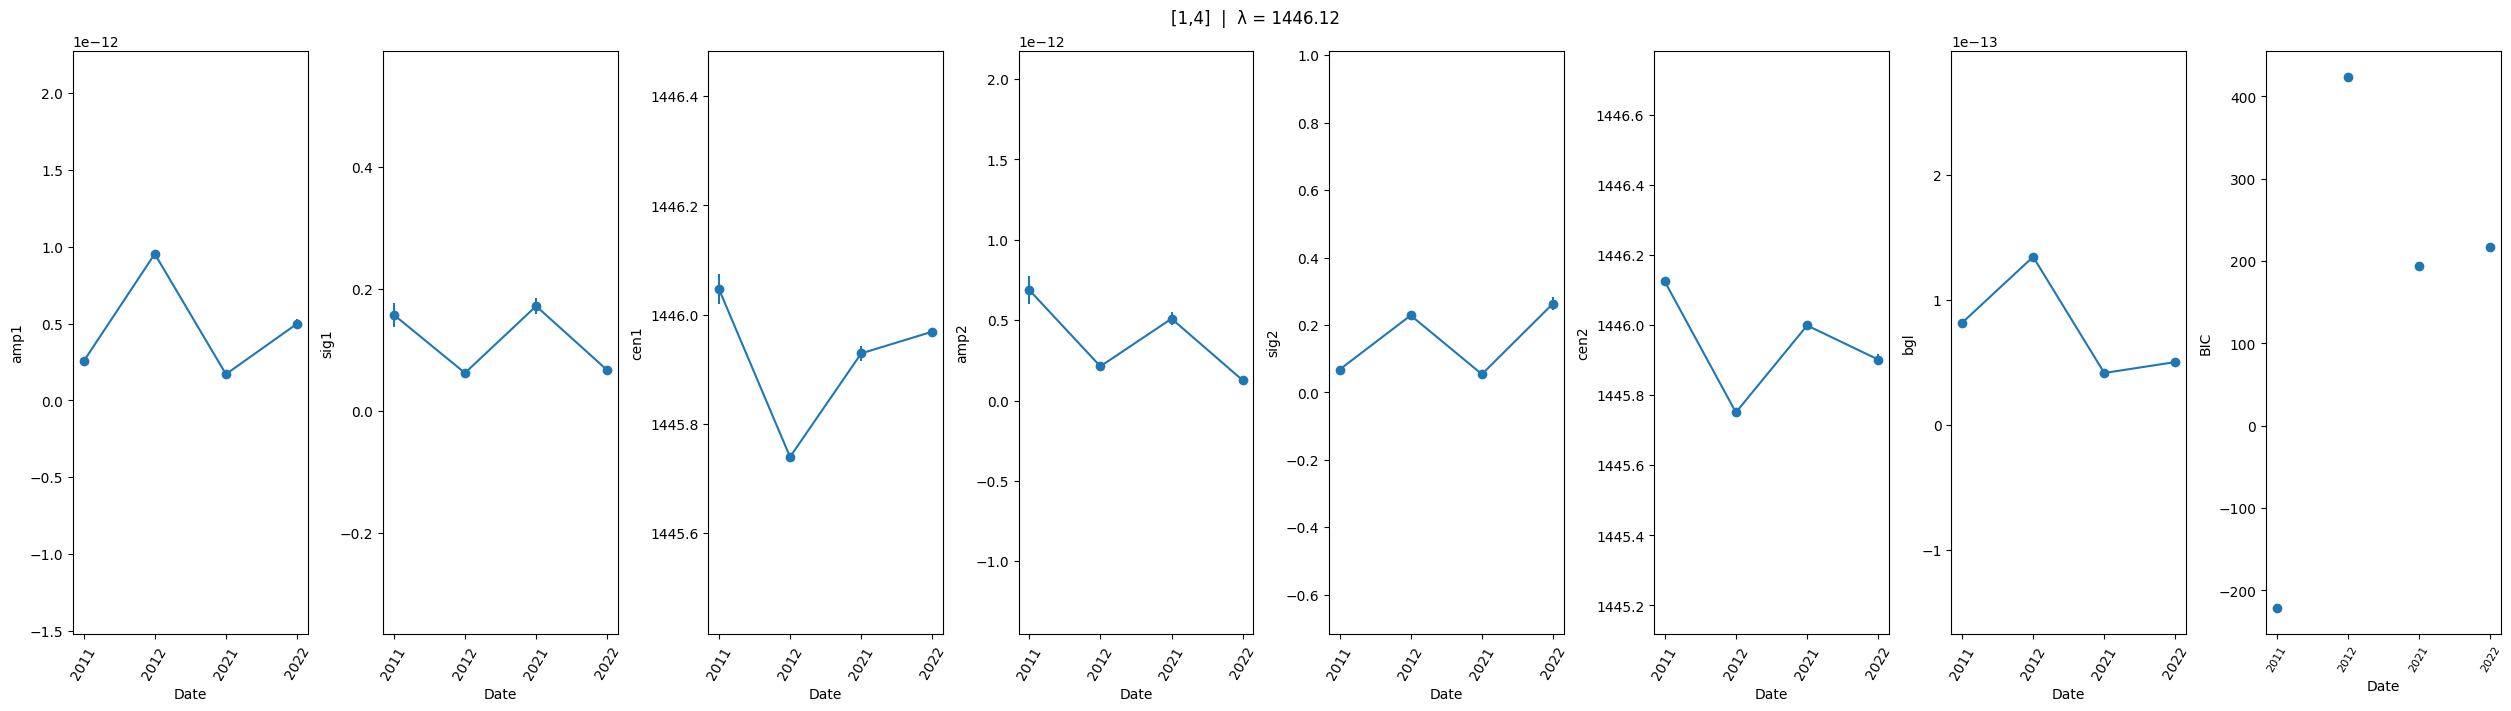

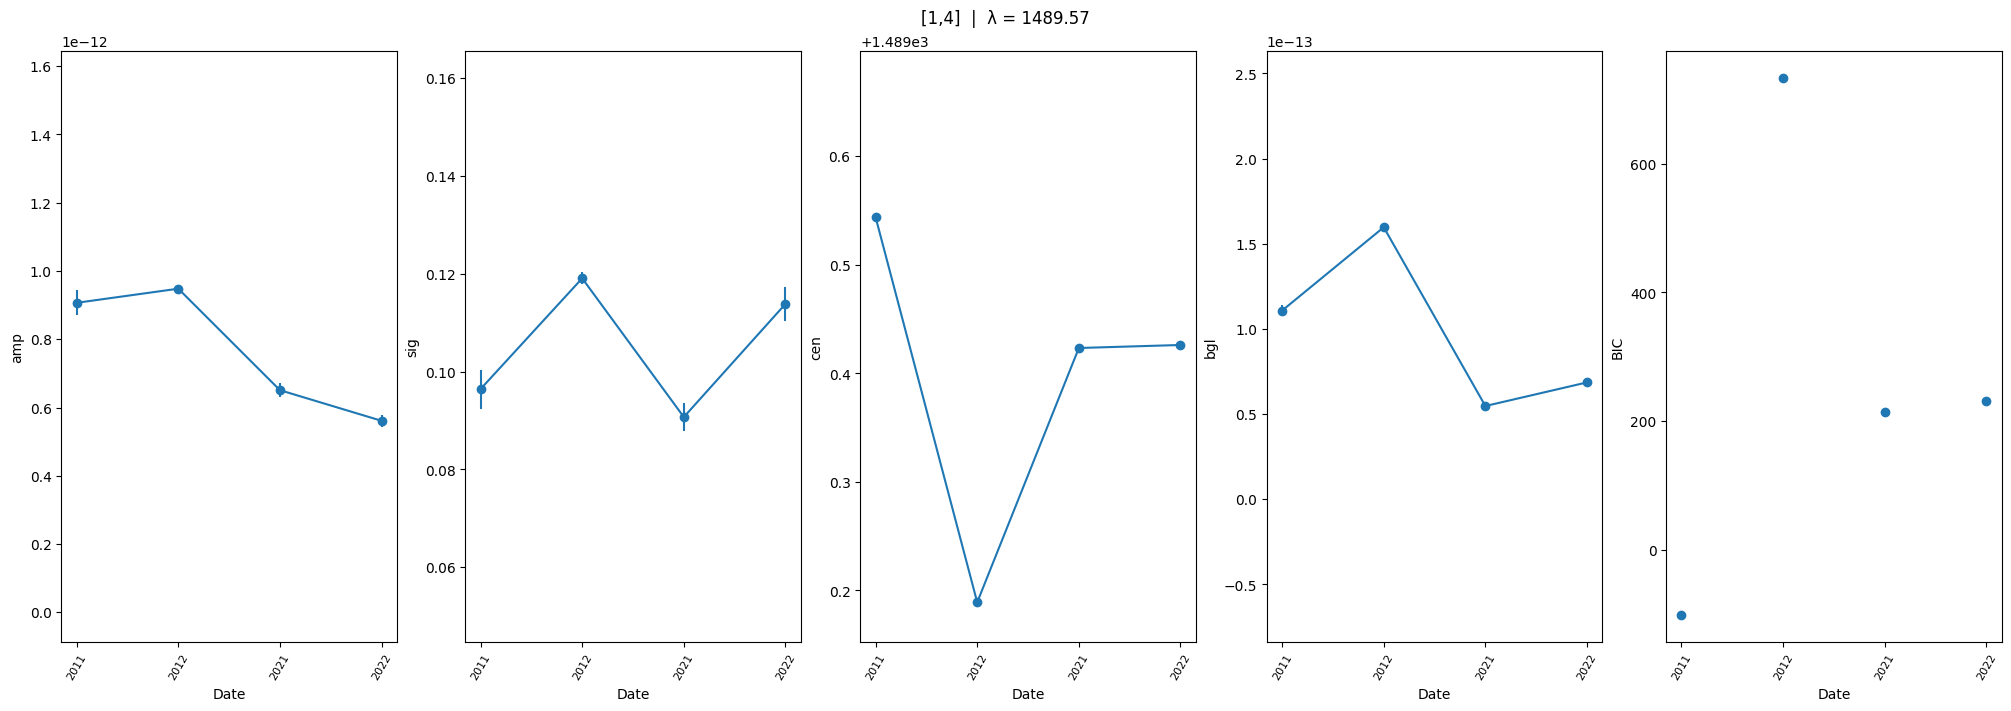

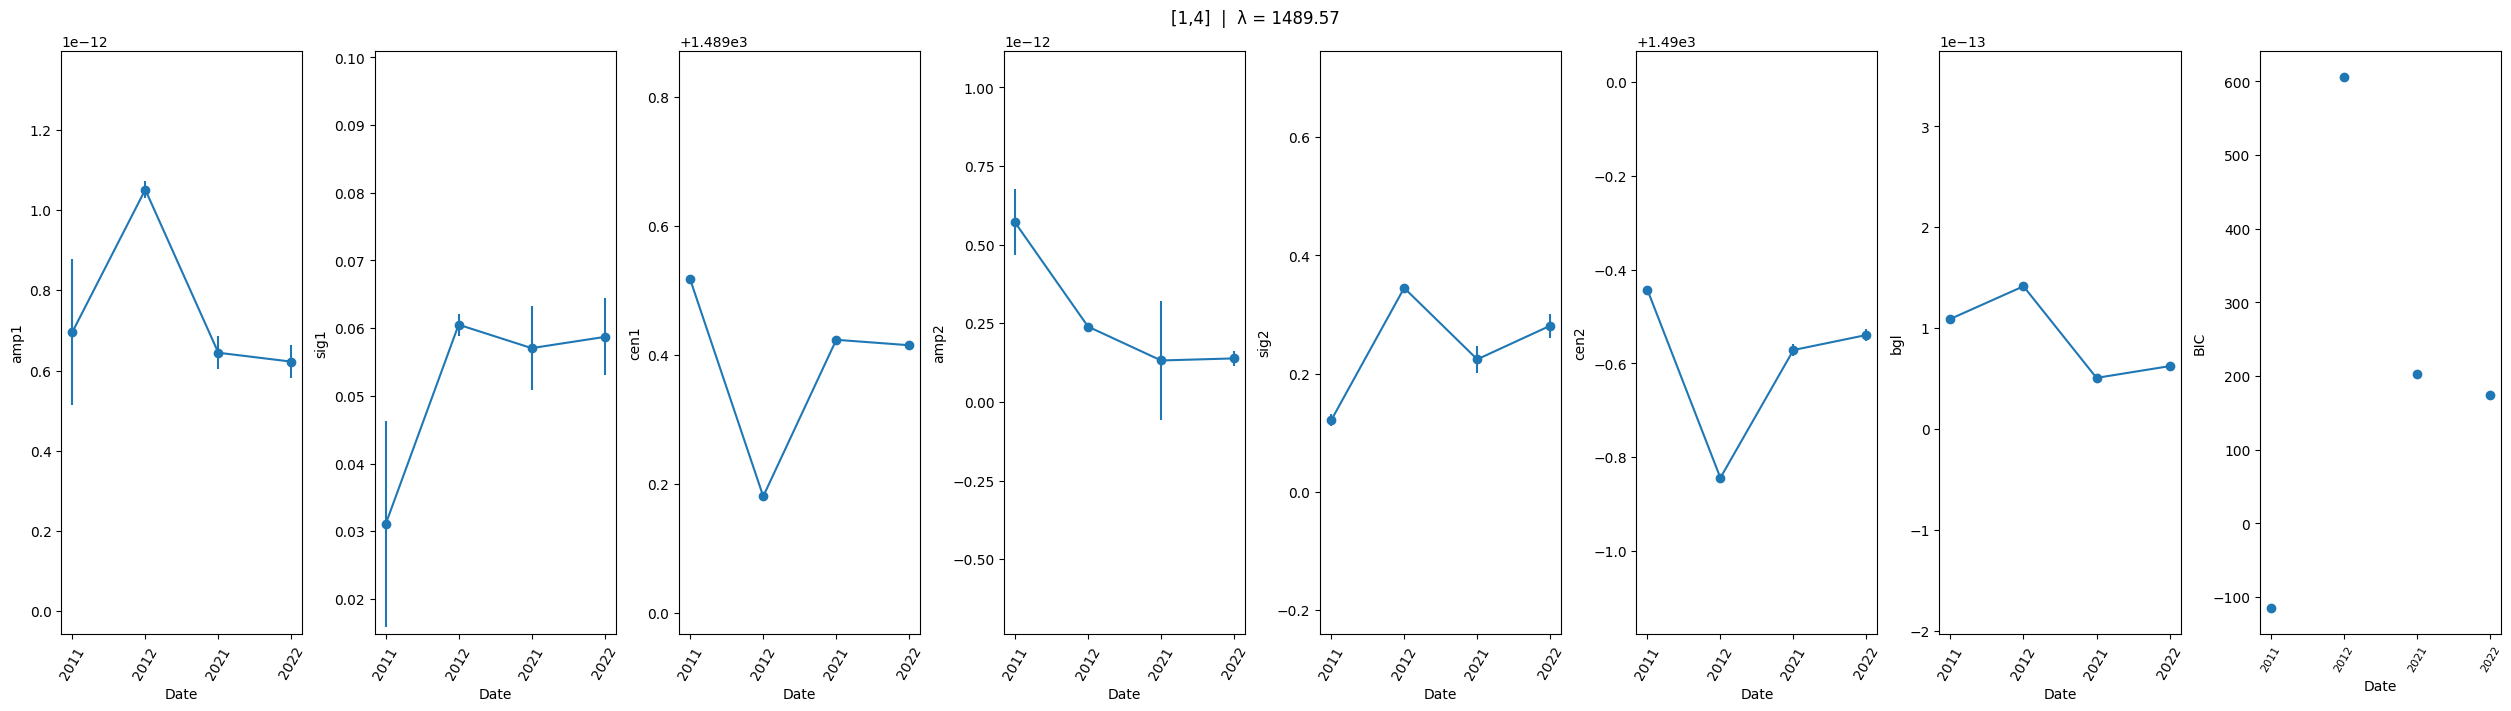

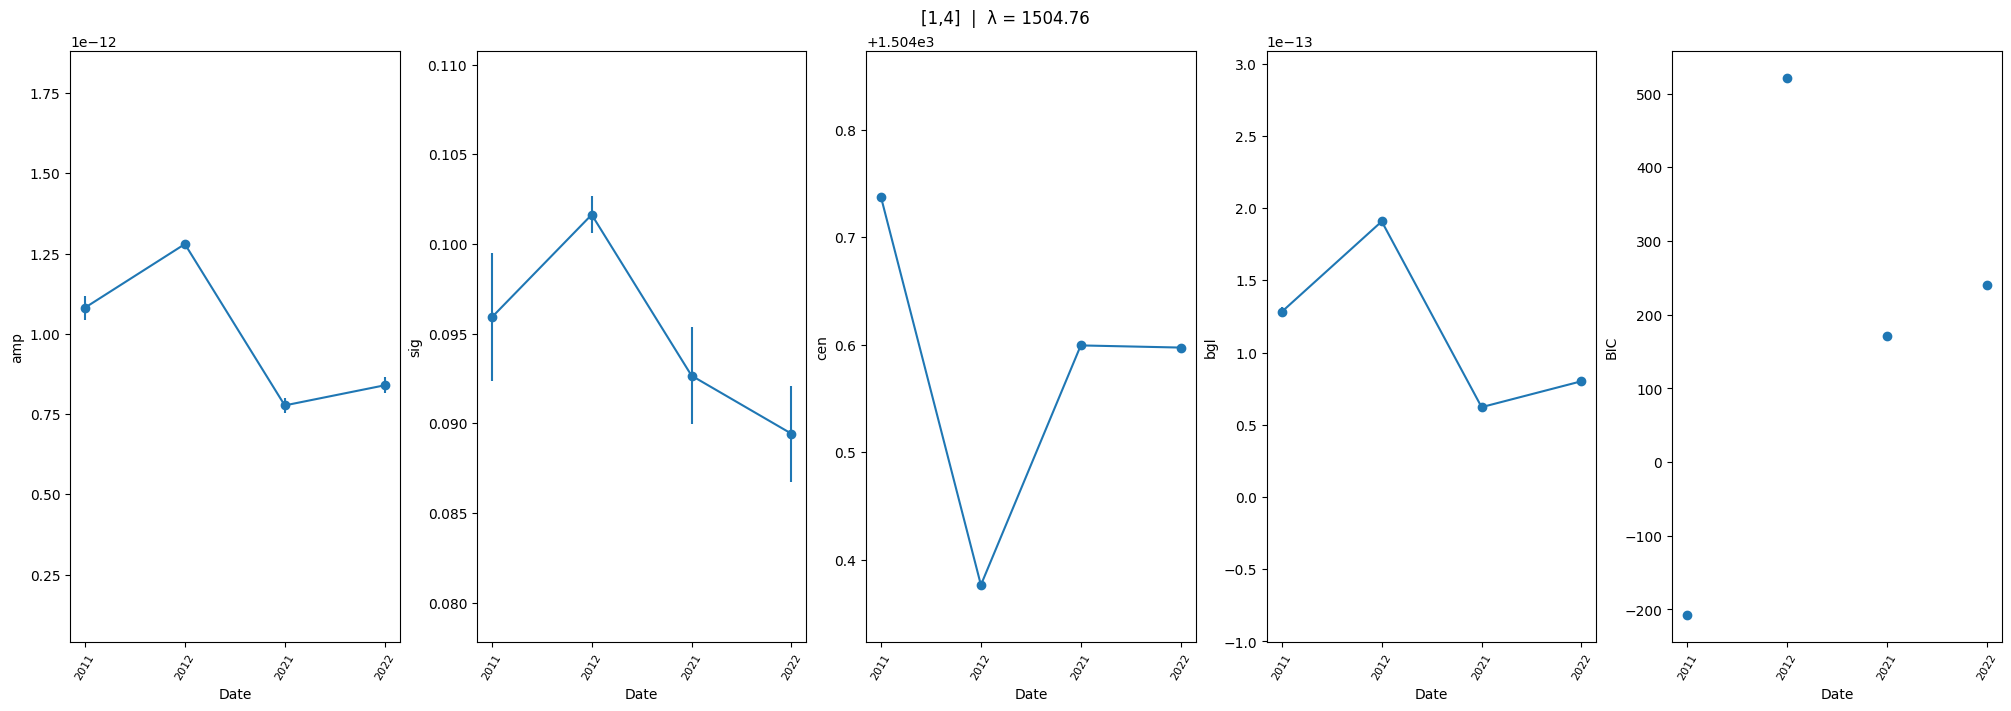

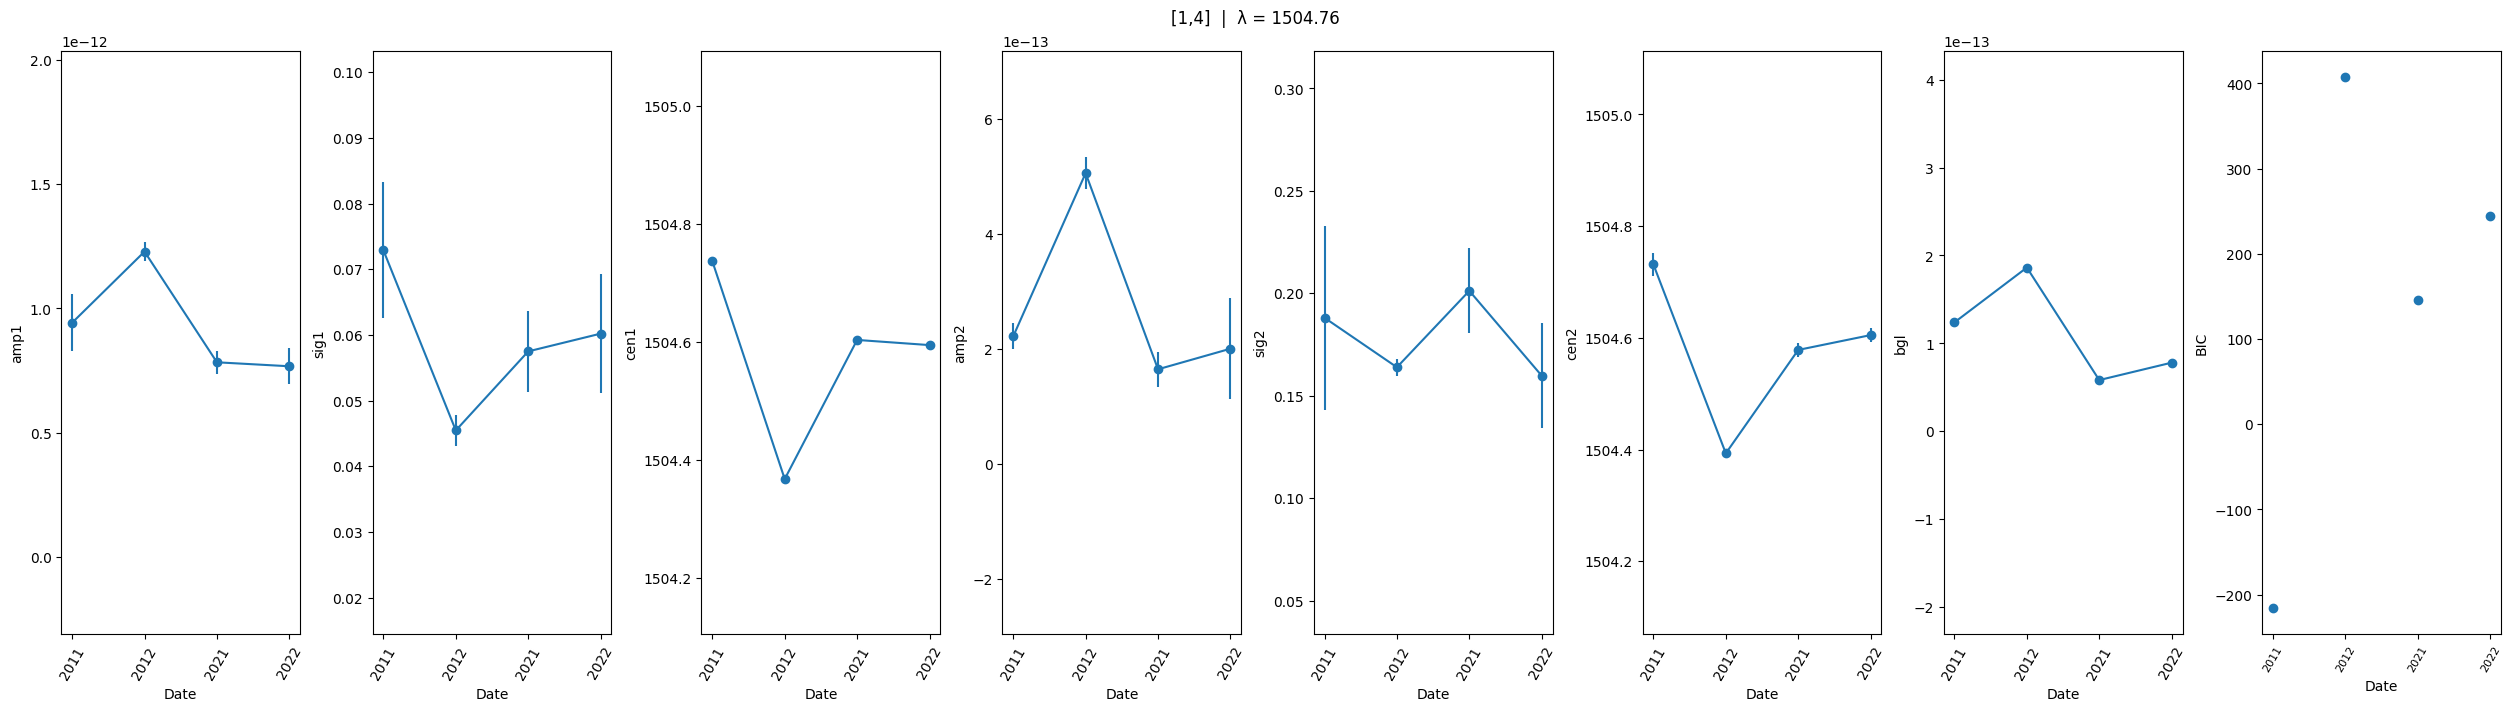

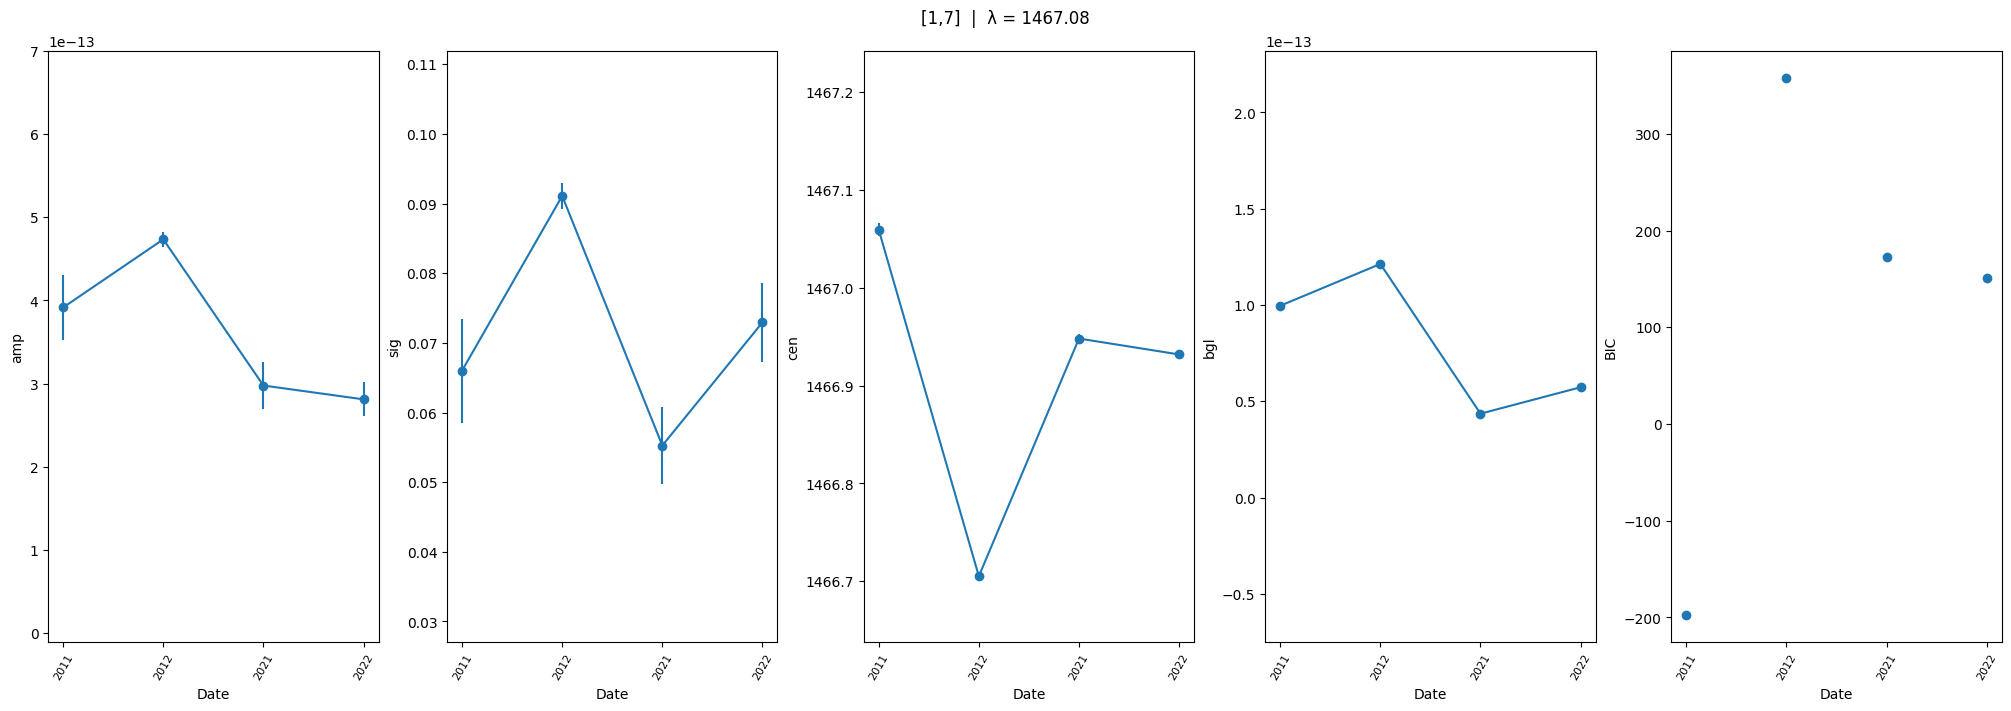

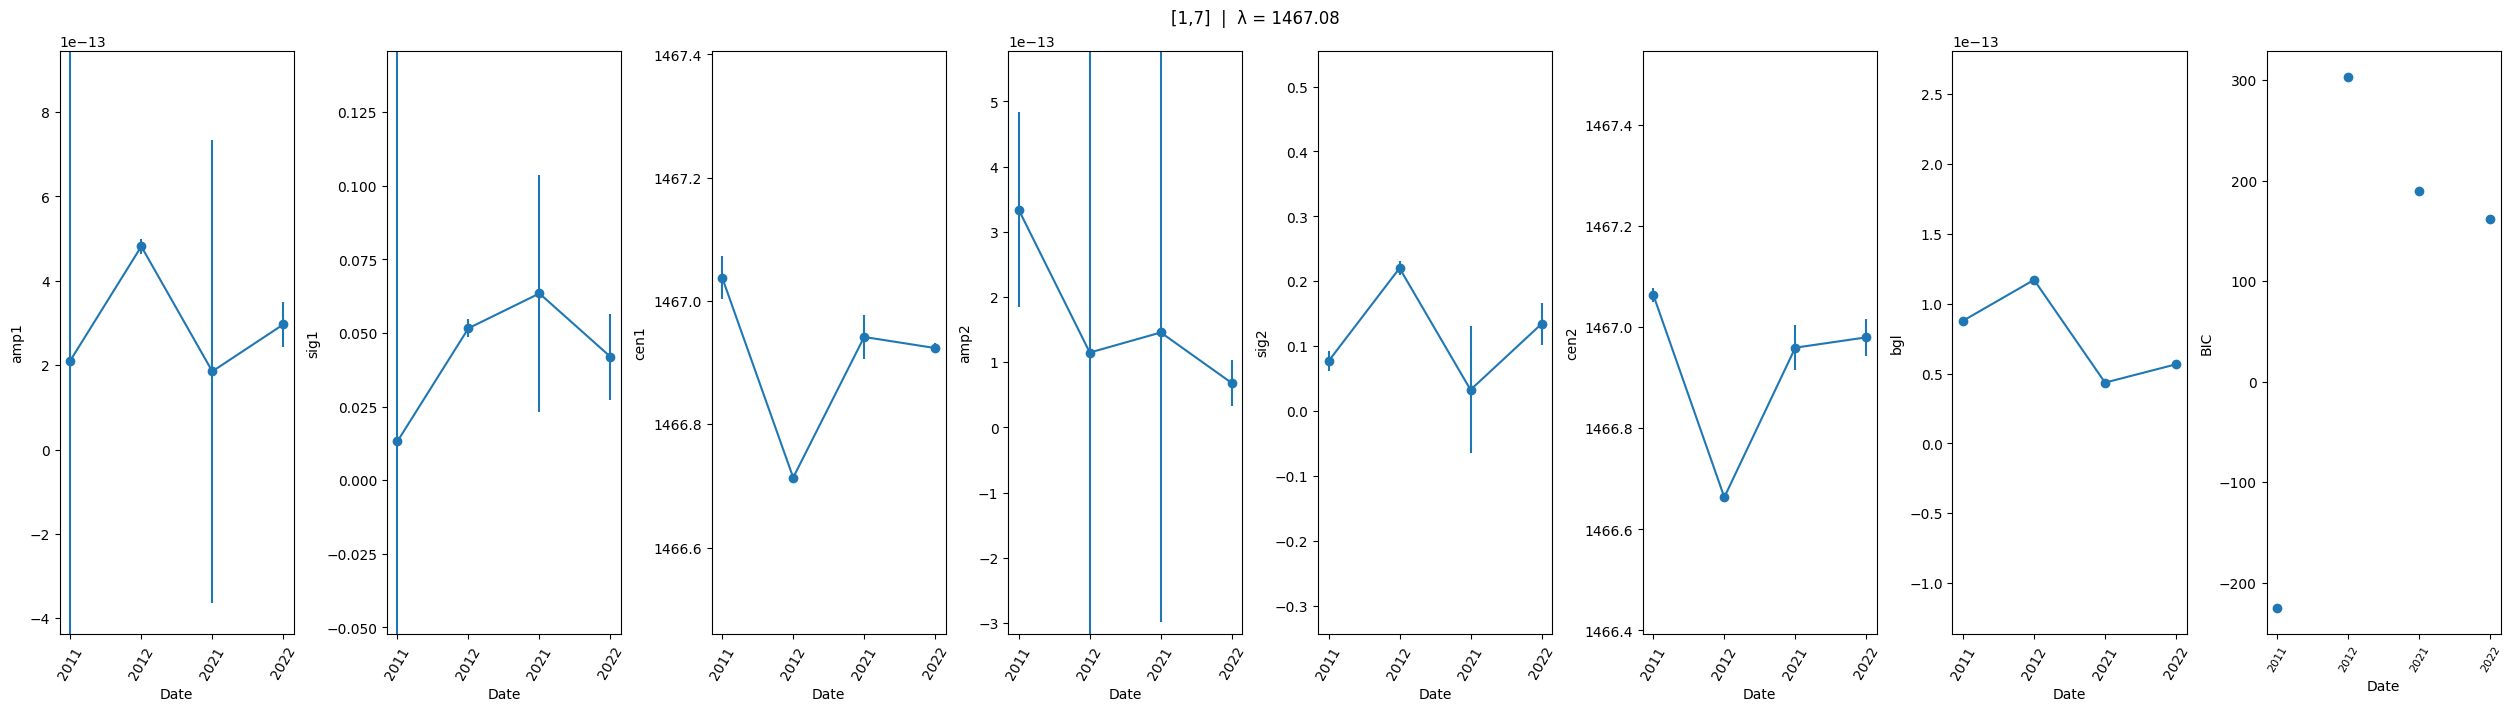

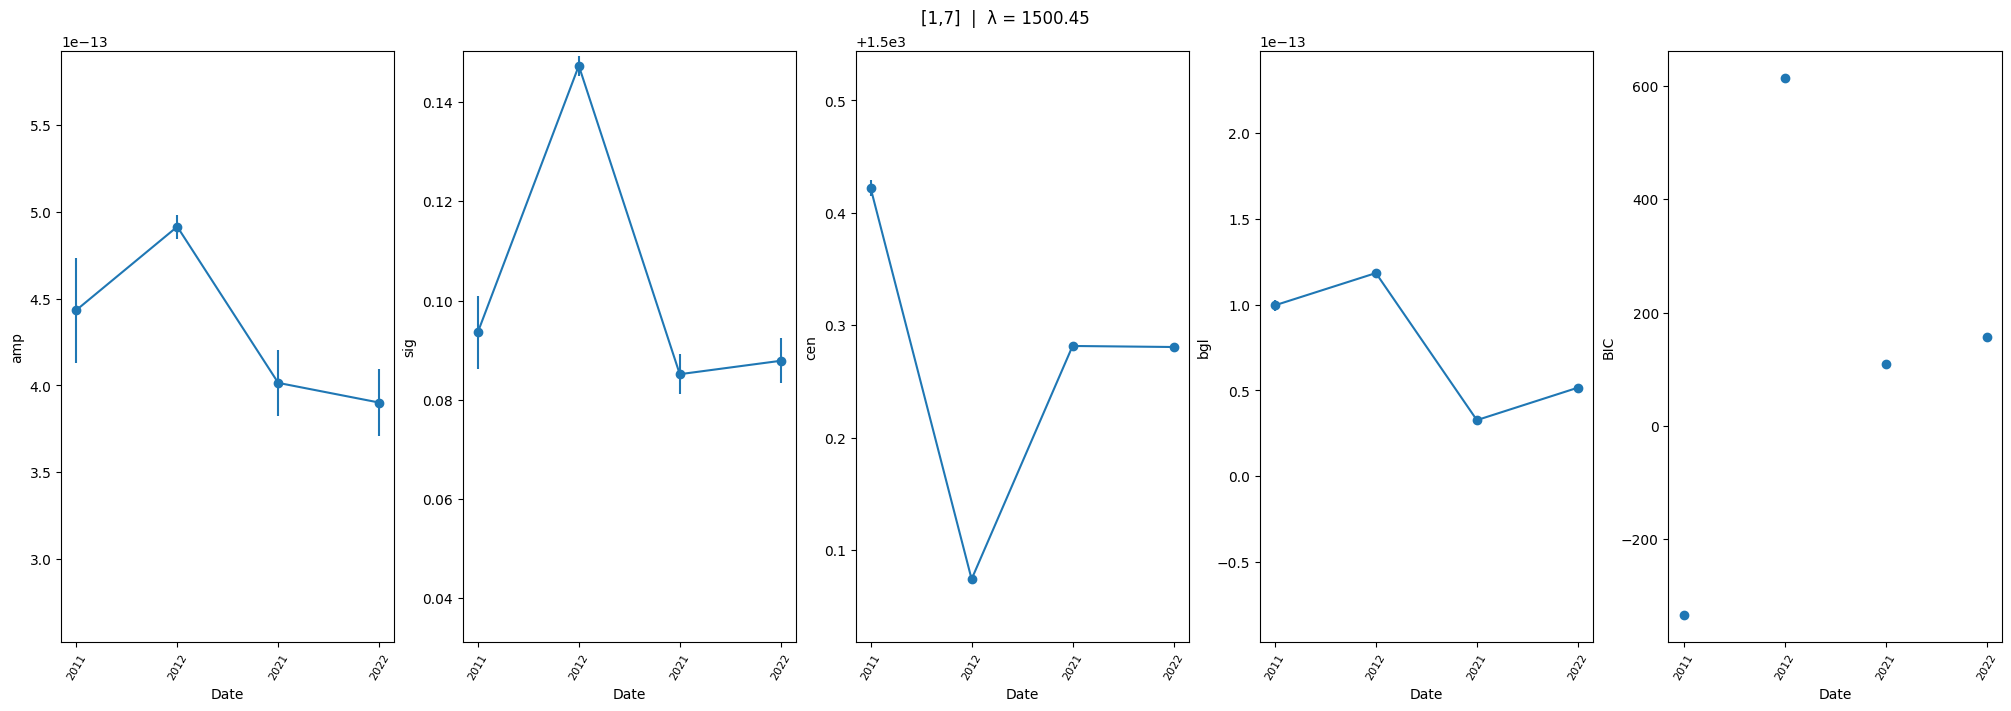

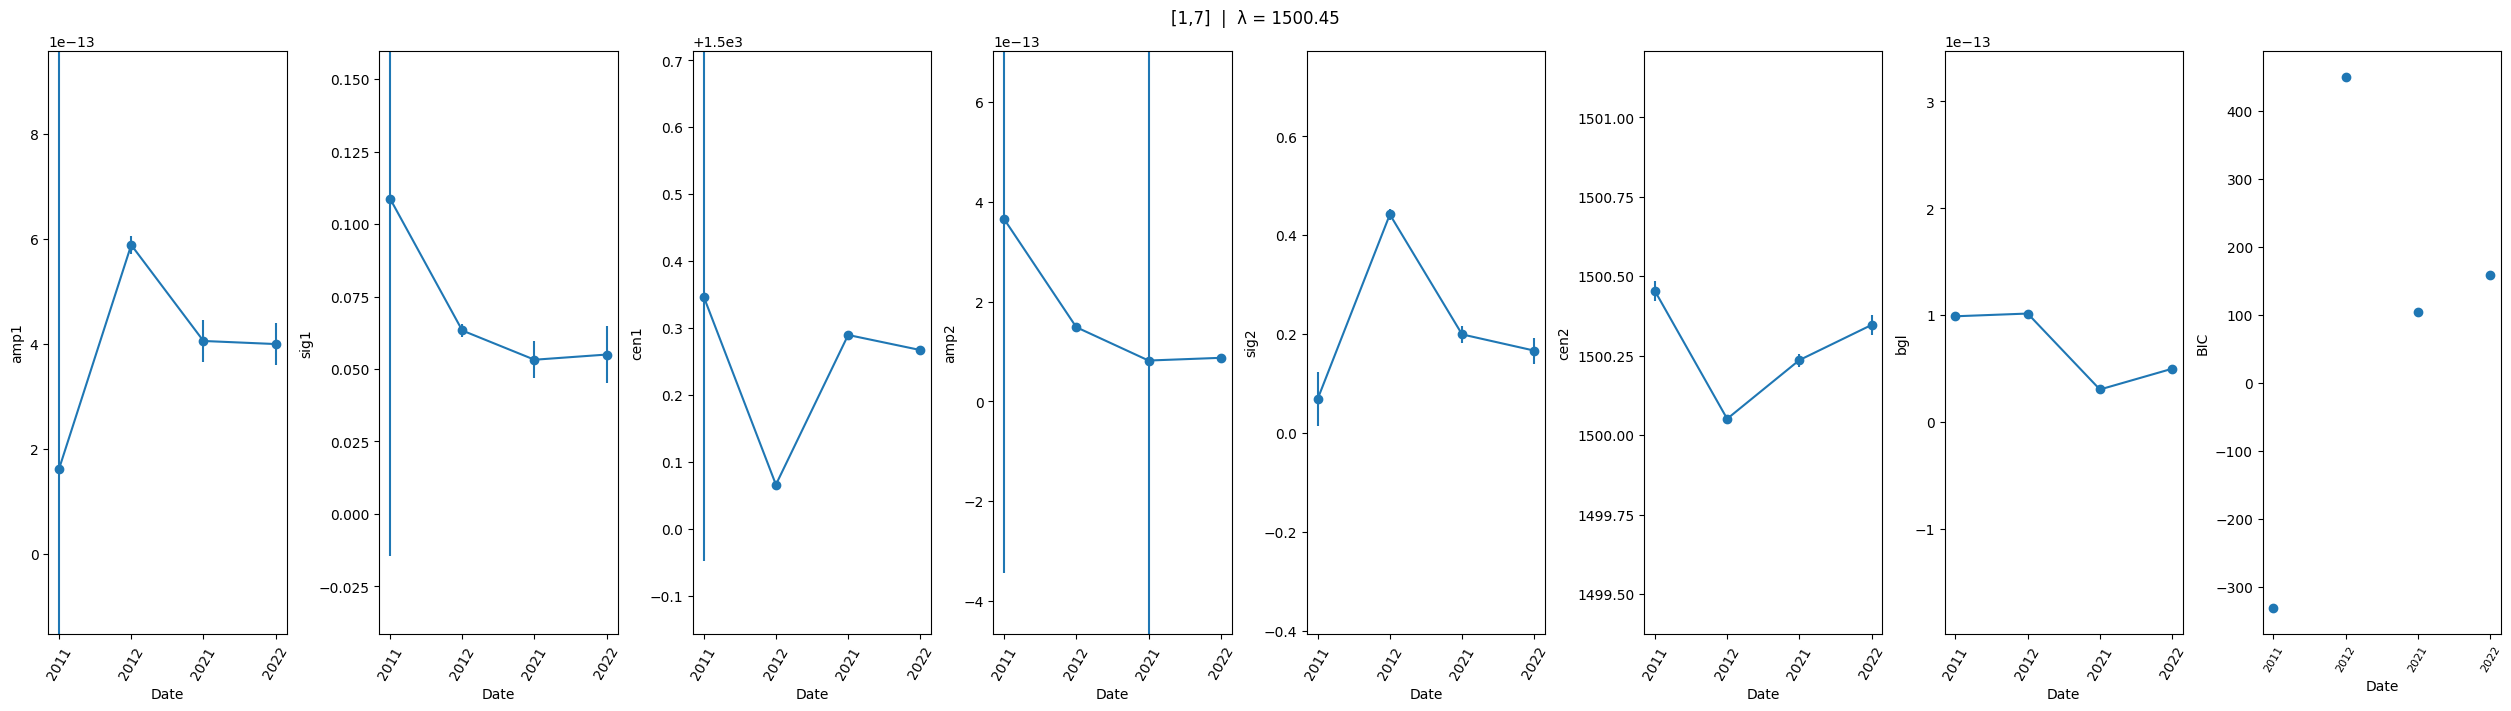

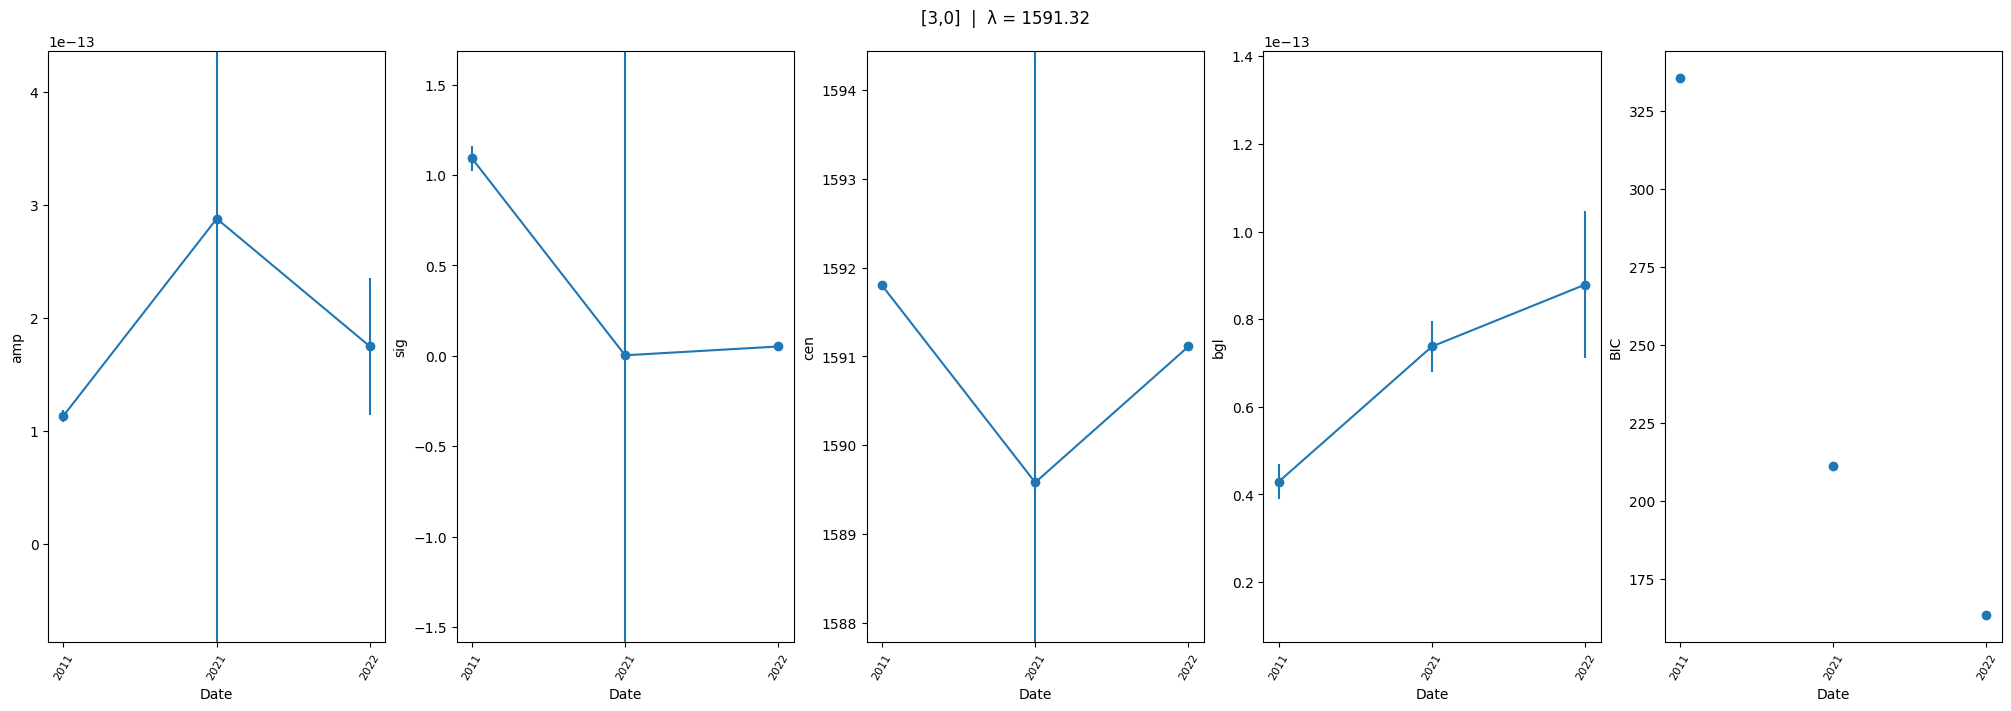

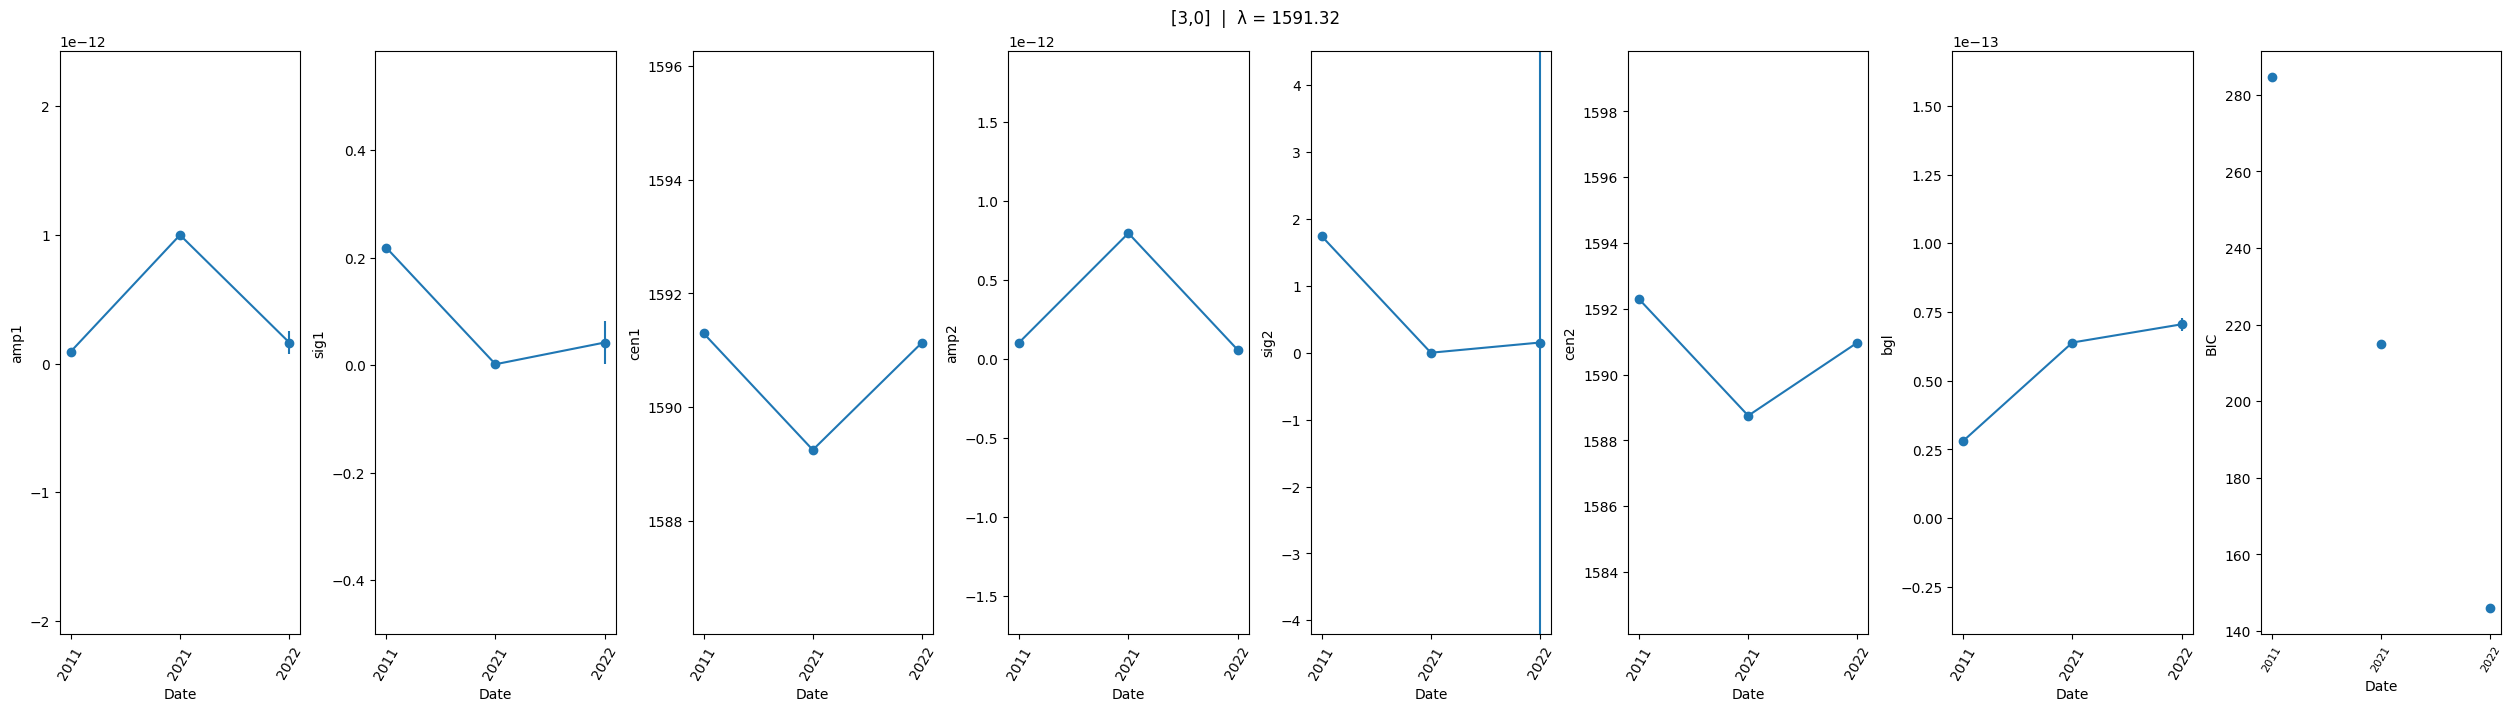

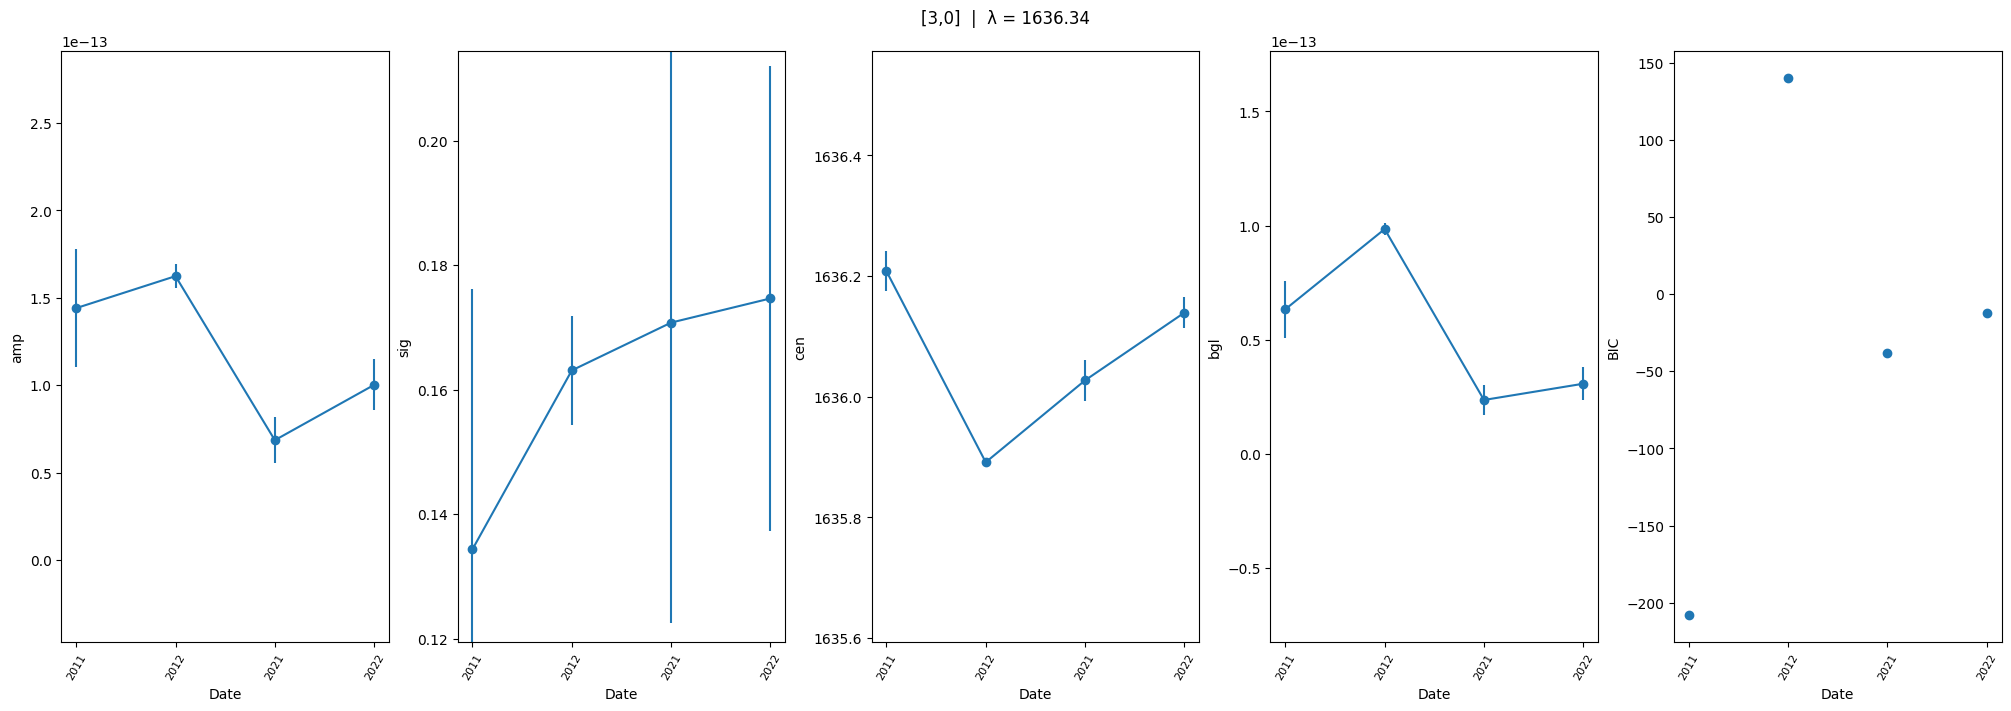

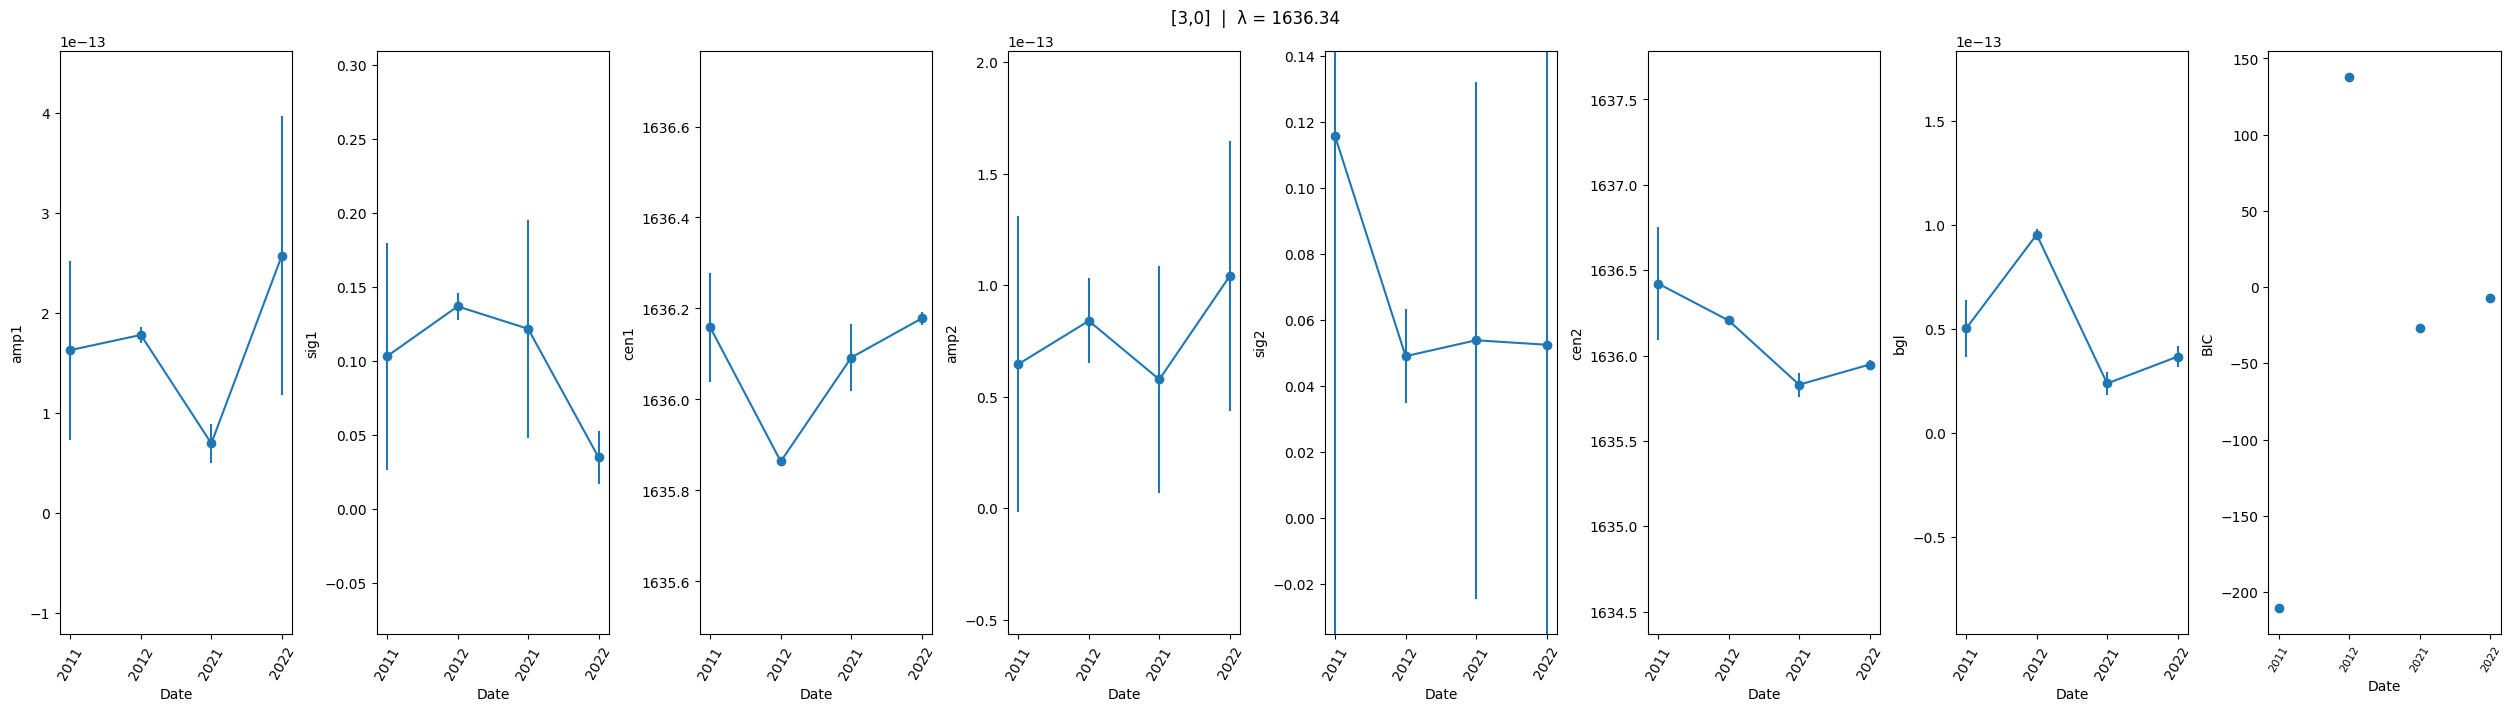

In [20]:
# Initialize fit_dict from the first row
params1_keys = line_df.iloc[0]['params1'].keys()
params2_keys = line_df.iloc[0]['params2'].keys()

# Loop through each unique (transition, labline) pair
for (transition, labline), sub_df in line_df.groupby(['transition', 'labline']):
    par_dict1 = {k: [] for k in params1_keys}
    err_dict1 = {k: [] for k in params1_keys}
    par_dict2 = {k: [] for k in params2_keys}
    err_dict2 = {k: [] for k in params2_keys}

    #obsdates = pd.to_datetime(sub_df['obsdate']).dt.strftime("%Y-%m-%d").tolist()
    obsdates = pd.to_datetime(sub_df['year']).dt.strftime("%Y").tolist()
    x_vals = range(len(obsdates))

    # Extract parameter values and uncertainties
    for _, row in sub_df.iterrows():
        for k, (val, err) in row['params1'].items():
            par_dict1[k].append(val)
            err_dict1[k].append(np.nan if err is None else err)
        for k, (val, err) in row['params2'].items():
            par_dict2[k].append(val)
            err_dict2[k].append(np.nan if err is None else err)

    # --- Plot single Gaussian (params1) ---
    fig, ax = plt.subplots(1, len(params1_keys)+1, figsize=(20, 7), layout='constrained')
    if len(params1_keys) == 1:
        ax = [ax]  # make iterable

    for i, key in enumerate(params1_keys):
        vals = np.array(par_dict1[key], dtype=float)
        errs = np.array(err_dict1[key], dtype=float)

        ax[i].errorbar(x_vals, vals, yerr=errs, marker='o')
        ax[i].set_ylabel(key)
        ax[i].set_xlabel('Date')
        ax[i].set_xticks(x_vals)
        ax[i].set_xticklabels(obsdates, rotation=60, fontsize=8)

        # --- Apply robust y-limits (ignore extreme errorbars) ---
        finite_vals = vals[np.isfinite(vals)]
        if len(finite_vals) > 0:
            median = np.nanmedian(finite_vals)
            iqr = np.nanpercentile(finite_vals, 75) - np.nanpercentile(finite_vals, 25)
            ax[i].set_ylim(median - 3 * iqr, median + 3 * iqr)
    
    ax[len(params1_keys)].scatter(x_vals, sub_df['BIC1'])
    ax[len(params1_keys)].set_ylabel('BIC')
    ax[len(params1_keys)].set_xlabel('Date')
    ax[len(params1_keys)].set_xticks(x_vals)
    ax[len(params1_keys)].set_xticklabels(obsdates, rotation=60, fontsize=8)
    
    fig.suptitle(f"{transition}  |  λ = {labline}")
    plt.show()

    # --- Plot double Gaussian (params2) ---
    fig2, ax2 = plt.subplots(1, len(params2_keys)+1, figsize=(25, 7), layout='constrained')
    if len(params2_keys) == 1:
        ax2 = [ax2]

    for i, key in enumerate(params2_keys):
        vals = np.array(par_dict2[key], dtype=float)
        errs = np.array(err_dict2[key], dtype=float)

        ax2[i].errorbar(x_vals, vals, yerr=errs, marker='o')
        ax2[i].set_ylabel(key)
        ax2[i].set_xlabel('Date')
        ax2[i].set_xticks(x_vals)
        ax2[i].set_xticklabels(obsdates, rotation=60, fontsize=10)

        # --- Robust y-limits ---
        finite_vals = vals[np.isfinite(vals)]
        if len(finite_vals) > 0:
            median = np.nanmedian(finite_vals)
            iqr = np.nanpercentile(finite_vals, 75) - np.nanpercentile(finite_vals, 25)
            ax2[i].set_ylim(median - 5 * iqr, median + 5 * iqr)

    ax2[len(params2_keys)].scatter(x_vals, sub_df['BIC2'])
    ax2[len(params2_keys)].set_ylabel('BIC')
    ax2[len(params2_keys)].set_xlabel('Date')
    ax2[len(params2_keys)].set_xticks(x_vals)
    ax2[len(params2_keys)].set_xticklabels(obsdates, rotation=60, fontsize=8)

    fig2.suptitle(f"{transition}  |  λ = {labline}")
    plt.show()

# BIC analysis

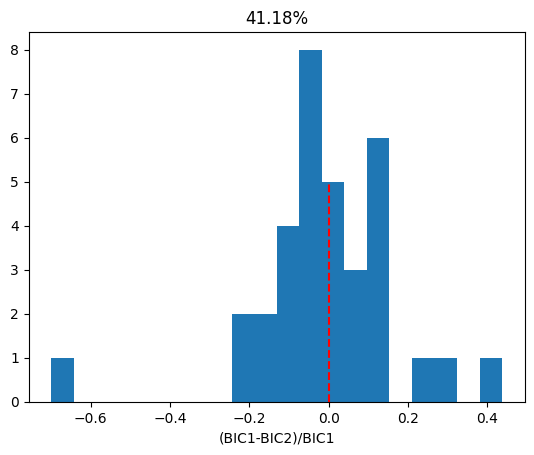

In [6]:
#overall BIC diff
sub_df = line_df[line_df['obsdate']!='2012-02-28']
all_bic_diff = (sub_df['BIC1'] - sub_df['BIC2'])/sub_df['BIC1']
plt.hist(all_bic_diff, bins=20)
plt.vlines(0, 0, 5, 'r', '--')
plt.title(f'{100*len(all_bic_diff[all_bic_diff>0])/len(sub_df):0.2f}%')
plt.xlabel('(BIC1-BIC2)/BIC1')
plt.show()

In [ ]:
#plot by labline
for l in line_df['labline'].unique():
    sub_df = line_df[line_df['labline']==l]
    transition = sub_df['transition'].iloc[0]
    bic_diff = (sub_df['BIC1'] - sub_df['BIC2'])/sub_df['BIC1']
    plt.hist(bic_diff)
    plt.vlines(0, 0, 2, 'r', '--')
    plt.title(f'{l} {transition} {100*len(bic_diff[bic_diff>0])/len(sub_df):0.2f}%')
    plt.xlabel('(BIC1-BIC2)/BIC1')
    plt.show()

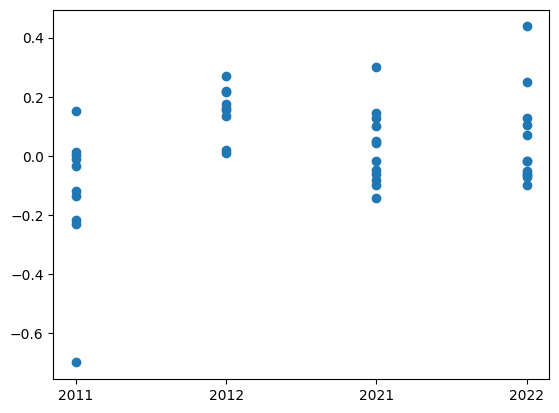

In [8]:
#All relative BICs by year, transition
#overall BIC diff
line_bic_diff = (line_df['BIC1'] - line_df['BIC2'])/line_df['BIC1']
plt.scatter(line_df['year'], line_bic_diff)
plt.show()

## Simulated Gaussian Fitting

In [65]:
#simulate gaussians to get a threshold of BIC differences
def gaussian(x, amp, sig, cen, bgl):
    x = np.array(x)
    y = amp * np.exp(-((x - cen)**2.0)/(2.0 * (sig**2.0))) + bgl
    return y

def double_gauss(x, amp1, sig1, cen1, amp2, sig2, cen2, bgl):
    y = gaussian(x, amp1, sig1, cen1,0) + gaussian(x, amp2, sig2, cen2,0) + bgl
    return y

x = np.linspace(-50,50,500)
gauss_opt = {'amp':[1,3,6,8],
             'sig':[2,1,10],
             'cen':[-10,-5,0,5],
             'bgl':0
            }

#want to switch narrow and broad components sometimes
double_gauss_opt = {'amp1':[0.5,1,3,5,6,9],
                    'sig1':[1, 2, 3],
                    'cen1':[-10,-5,0,5],
                    'amp2':[0.5,1,3,5,6,9],
                    'sig2':[1, 2, 3],
                    'cen2':[-9,-4,1,6],
                    'bgl':0
                    }
def gen_simspec():
    model = np.random.randint(0,2,size=1)[0]
    
    noise = np.random.rand(500)

    if model==1:
        amp,sig,cen,bgl = [gauss_opt['amp'][np.random.randint(0,4,size=1)[0]],
                       gauss_opt['sig'][np.random.randint(0,3,size=1)[0]],
                       gauss_opt['cen'][np.random.randint(0,4,size=1)[0]],
                       gauss_opt['bgl']]
        y = gaussian(x, amp, sig, cen, bgl)
    if model==0:
        amp1,sig1,cen1,amp2,sig2,cen2,bgl = [double_gauss_opt['amp1'][np.random.randint(0,6,size=1)[0]],
                       double_gauss_opt['sig1'][np.random.randint(0,3,size=1)[0]],
                       double_gauss_opt['cen1'][np.random.randint(0,4,size=1)[0]],
                       double_gauss_opt['amp2'][np.random.randint(0,6,size=1)[0]],
                       double_gauss_opt['sig2'][np.random.randint(0,3,size=1)[0]],
                       double_gauss_opt['cen2'][np.random.randint(0,4,size=1)[0]],
                       double_gauss_opt['bgl']]
        y = double_gauss(x,amp1,sig1,cen1,amp2,sig2,cen2,bgl)

    return y+noise, model

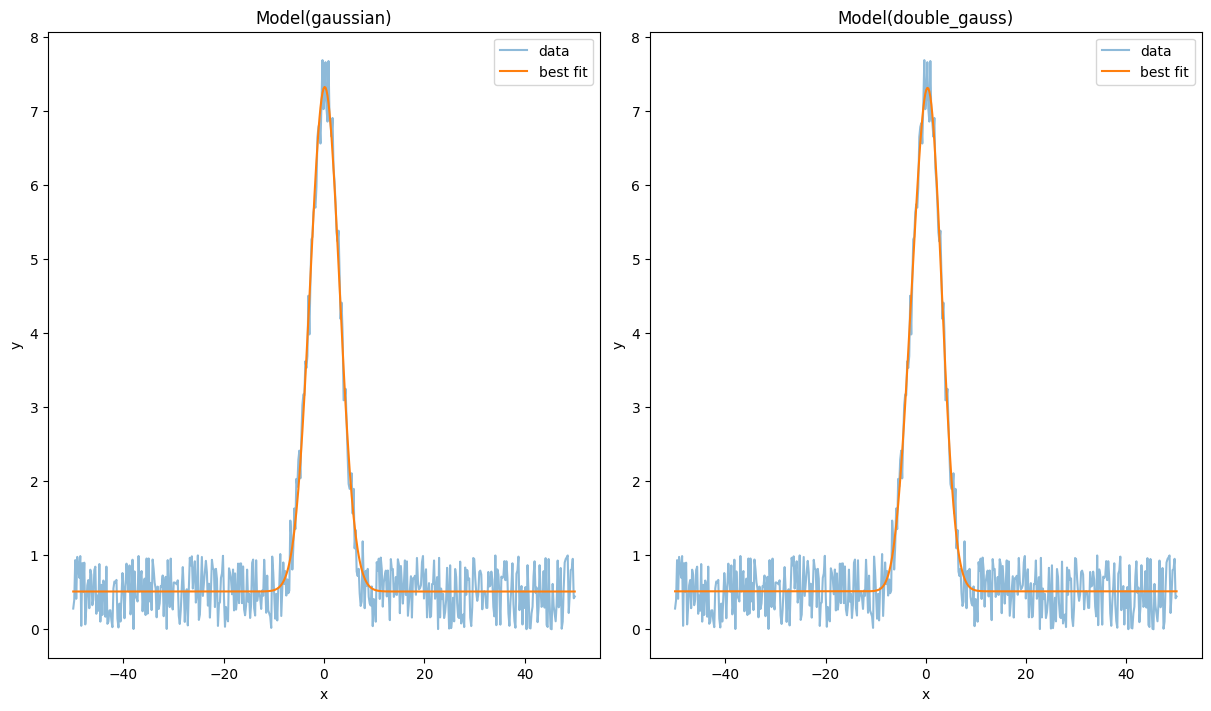

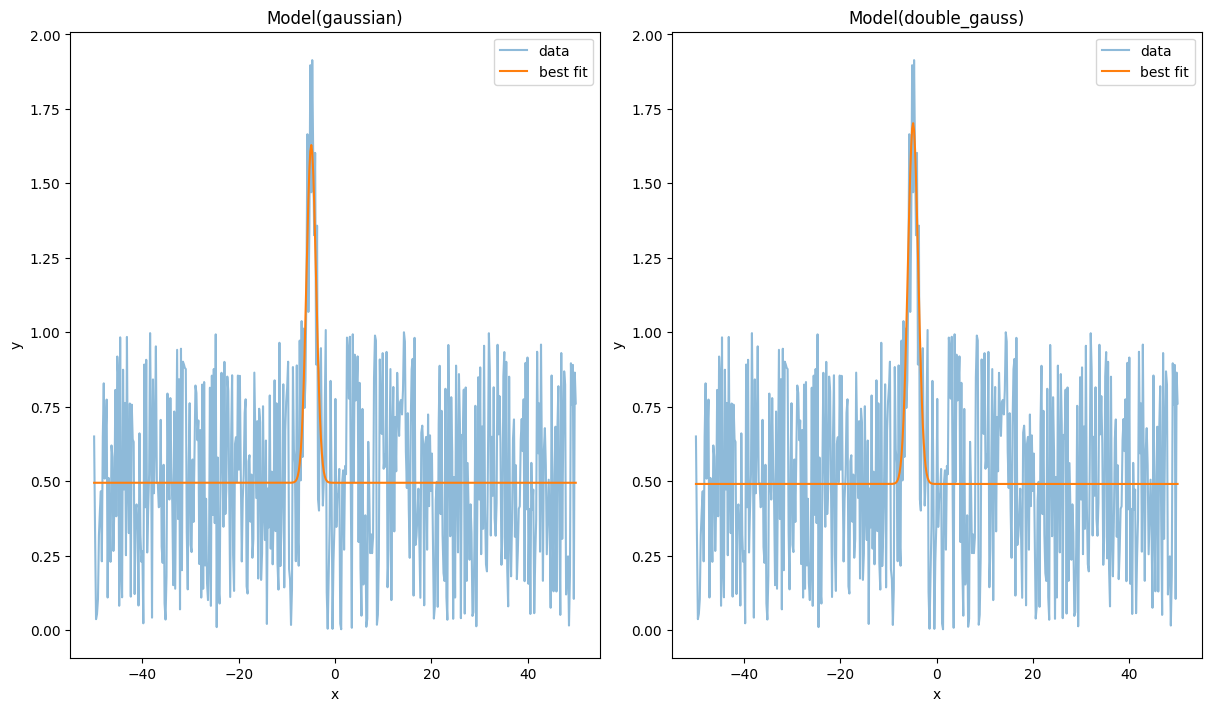

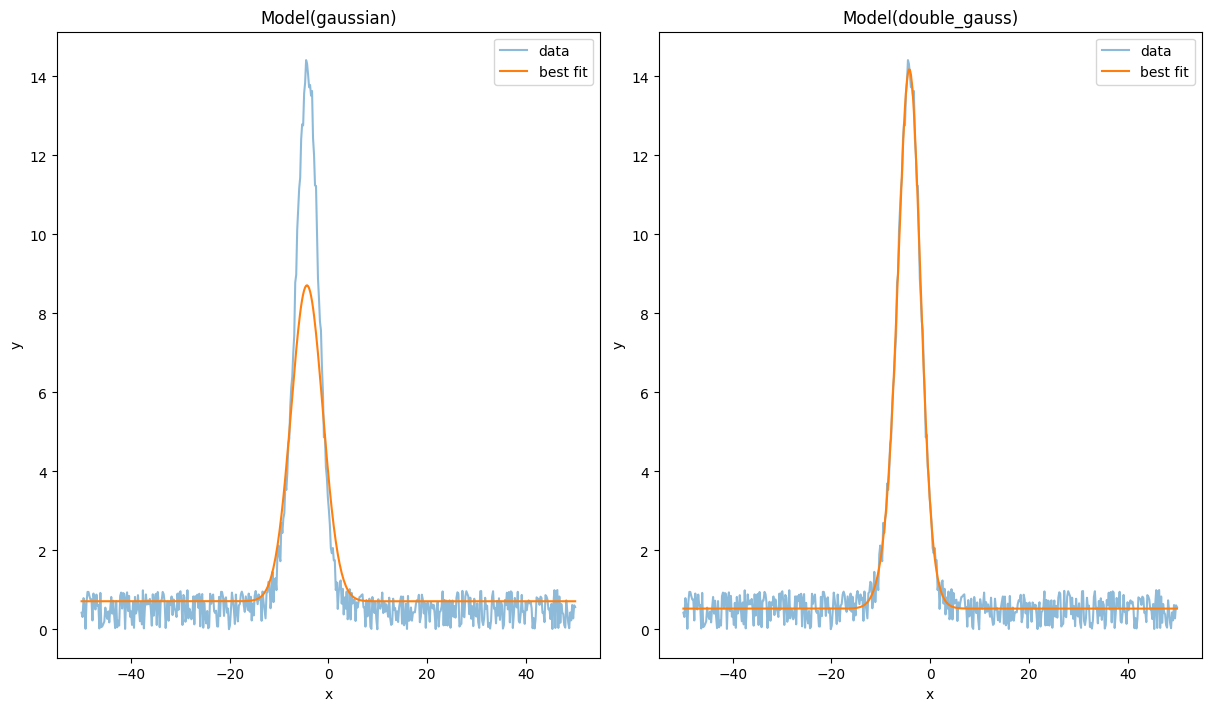

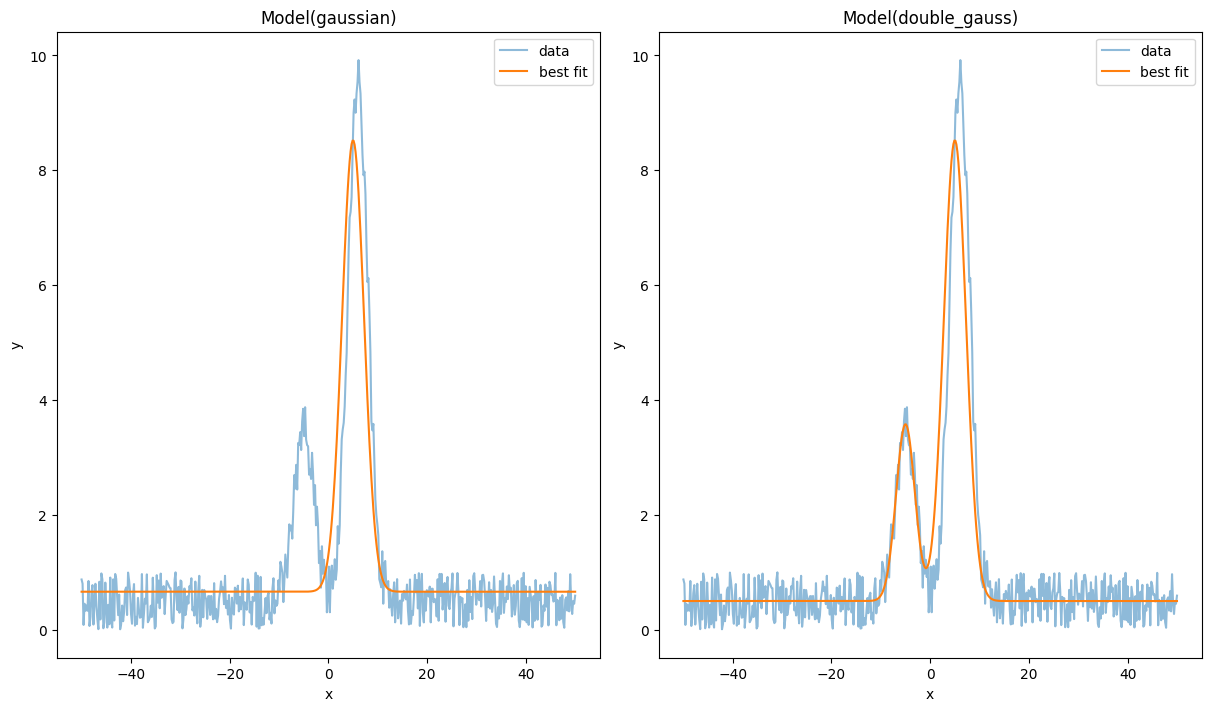

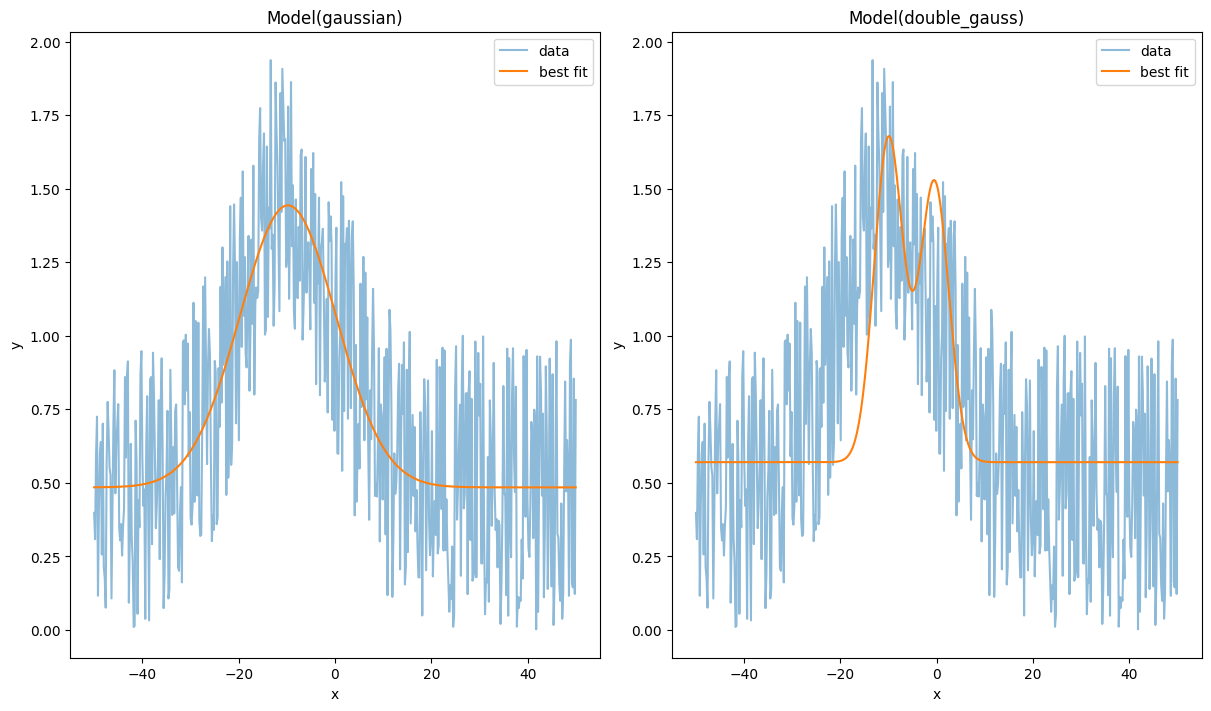

In [68]:
from lmfit import Model
fit_iter = 0
bic1 = []
bic2 = []
model_true = []
while fit_iter <= 5:
    y, model = gen_simspec()
    bgl_val = np.mean(y[:10])
    lineModel = Model(gaussian)
    doubleLineModel = Model(double_gauss)
    lineParam = lineModel.make_params(amp=np.max(y), sig=np.std(y), cen=x[np.argmax(y)], bgl = np.mean(y[:10]))
    line_bounds = {p: (min(vals), max(vals)) for p, vals in gauss_opt.items() if p !='bgl'}
    for p in lineParam:
        if p == 'amp':
            _, pmax = line_bounds[p]
            pmin = lineParam['bgl']*2
            lineParam[p].set(min=pmin, max=pmax)
        elif p!='bgl':
            pmin, pmax = line_bounds[p]
            lineParam[p].set(min=pmin, max=pmax)

    lineFit = lineModel.fit(y, lineParam, x=x, scale_covar=True, method='basinhopping')

    doubleLineParam = doubleLineModel.make_params(amp1=np.max(y),
                                                  sig1=np.std(y), 
                                                  cen1=x[np.argmax(y)],
                                                  amp2=np.max(y),
                                                  sig2=0.5, 
                                                  cen2=x[np.argmax(y)]-5,
                                                  bgl = bgl_val)
    double_line_bounds = {p: (min(vals), max(vals)) for p, vals in double_gauss_opt.items() if p !='bgl'}
    for p in doubleLineParam:
        if p == 'amp1' or p =='amp2':
            _, pmax = double_line_bounds[p]
            pmin = doubleLineParam['bgl']*2
            doubleLineParam[p].set(min=pmin, max=pmax)
        elif p!='bgl':
            pmin, pmax = double_line_bounds[p]
            doubleLineParam[p].set(min=pmin, max=pmax)
    doubleFit = doubleLineModel.fit(y, doubleLineParam, x=x, scale_covar=True, method='basinhopping')

    model_true.append(model)
    bic1.append(lineFit.bic)
    bic2.append(doubleFit.bic)
    if fit_iter<5:
        fig, axs = plt.subplots(1,2,layout='constrained', figsize = (12,7))
        lineFit.plot_fit(ax = axs[0], datafmt='', data_kws={'alpha':0.5})
        doubleFit.plot_fit(ax = axs[1], datafmt='', data_kws={'alpha':0.5})
        plt.show()

    fit_iter+=1


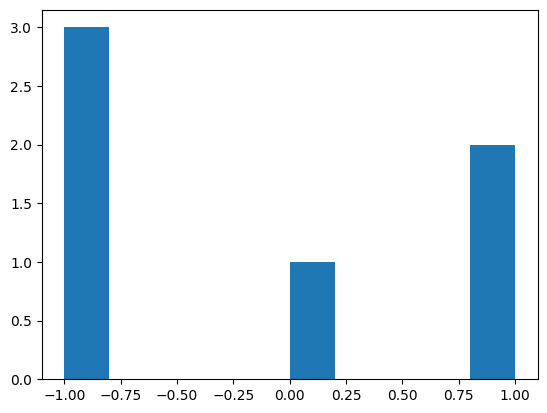

In [69]:
model_guess = np.array([1 if b1-b2 >= 0 else 0 for b1, b2 in zip(bic1, bic2)])
bic_diff = np.array(bic1)-np.array(bic2)
model_diff = model_guess-np.array(model_true)
plt.hist(model_diff)
plt.show()